#  Data & IA Project
### Aymene Mazouz - Yasmina Moussaoui - Toby Pollock

## Objectif du Projet
Les maladies cardiaques constituent l'une des principales causes de mortalité dans le monde. La capacité à prédire le risque de développer une maladie cardiaque à partir de données médicales est cruciale pour mettre en place des mesures préventives adaptées, améliorer les traitements, et sauver des vies. Ce projet a pour but de développer un modèle prédictif capable d'évaluer le risque qu'un patient soit atteint d'une maladie cardiaque en se basant sur ses données cliniques, et ceci avec une bonne precision.
pas de préprocesseur, knn inputer to handle nanvlues 

## Description des Données
Le dataset utilisé dans ce projet, intitulé heart_disease_data.csv, contient les informations médicales de plusieurs patients.
Les attributs de ces données sont les suivants :
- **Age** : âge du patient (en années).
- **Sex** : sexe du patient (M : Homme, F : Femme).
- **ChestPainType** : type de douleur thoracique (TA : Angine typique, ATA : Angine atypique, NAP : Douleur non angineuse, ASY : Asymptomatique).
- **RestingBP** : tension artérielle au repos (en mm Hg).
- **Cholesterol** : cholestérol sérique (en mg/dl).
- **FastingBS** : glycémie à jeun (1 : si > 120 mg/dl, 0 : sinon).
- **RestingECG** : résultats de l’électrocardiogramme au repos (Normal : Normal, ST : anomalies ST-T, LVH : Hypertrophie ventriculaire gauche).
- **MaxHR** : fréquence cardiaque maximale atteinte.
- **ExerciseAngina** : angine provoquée par l’effort (Y : Oui, N : Non).
- **Oldpeak** : dépression du segment ST mesurée (valeur numérique).
- **ST_Slope** : pente du segment ST à l’effort (Up : ascendante, Flat : plate, Down :
descendante).
- **HeartDisease** : présence ou absence de maladie cardiaque (1 : Oui, 0 : Non).
- knn inputer 

In [1]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
# Import des bibliothèques nécessaires
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from imblearn.combine import SMOTEENN, SMOTETomek
# Pour l'équilibrage des classes
from imblearn.over_sampling import SMOTE
from scipy.stats import chi2_contingency, kendalltau, mannwhitneyu
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, f1_score, roc_curve, auc, roc_auc_score, precision_score, make_scorer,
                             recall_score)
# Pour la modélisation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
# Pour le prétraitement des données
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from statsmodels.stats.contingency_tables import mcnemar

In [2]:
# Configuration de l'affichage
plt.style.use('seaborn-v0_8-notebook')
sns.set_palette('Set2')

In [3]:
#Chargement des données
df = pd.read_csv('./data/heart_disease_data.csv')

In [4]:
#Affichage des premiéres lignes
display(df.head())

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## 1) ANalyse genérale

In [5]:
# Vérification des valeurs manquantes
print("\nValeurs manquantes :")
print(df.isnull().sum())


Valeurs manquantes :
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [6]:
#Informations générales 
print("Informations sur les données :")
df.info()

print("\nStatistiques descriptives :")
display(df.describe())
 

Informations sur les données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB

Statistiques descriptives :


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


### 1.1) Examen de la distribution de la target classe!

Distribution des classes:
Pas de maladie cardiaque (0): 44.66%
Maladie cardiaque (1): 55.34%


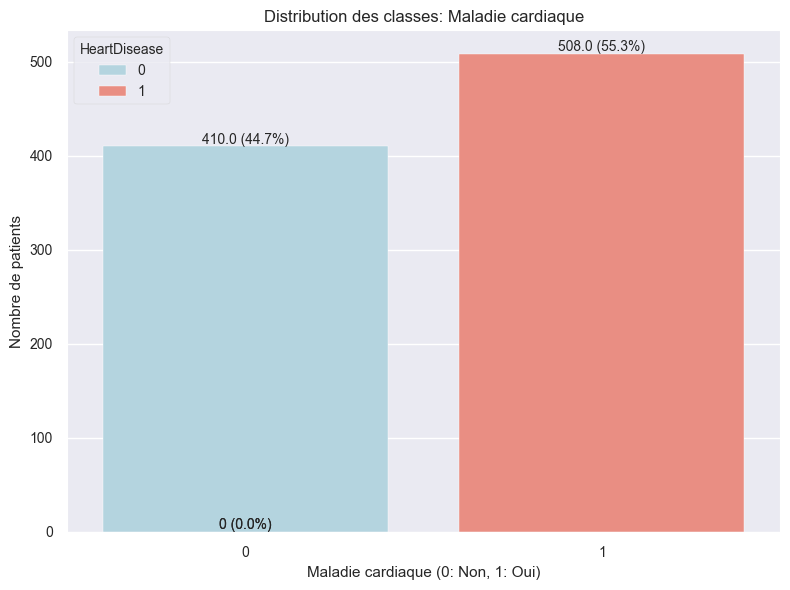

In [7]:
class_distribution = df['HeartDisease'].value_counts(normalize=True) * 100
print("Distribution des classes:")
print(f"Pas de maladie cardiaque (0): {class_distribution[0]:.2f}%")
print(f"Maladie cardiaque (1): {class_distribution[1]:.2f}%")

plt.figure(figsize=(8, 6))
ax = sns.countplot(x='HeartDisease', data=df, palette=['lightblue', 'salmon'], hue = 'HeartDisease')
plt.title('Distribution des classes: Maladie cardiaque')
plt.xlabel('Maladie cardiaque (0: Non, 1: Oui)')
plt.ylabel('Nombre de patients')

# Ajout des pourcentages sur le graphique
total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 3,
            f'{height} ({height/total*100:.1f}%)',
            ha="center")
plt.tight_layout()
plt.show()

### 1.2 Analyse des variables catégorielles

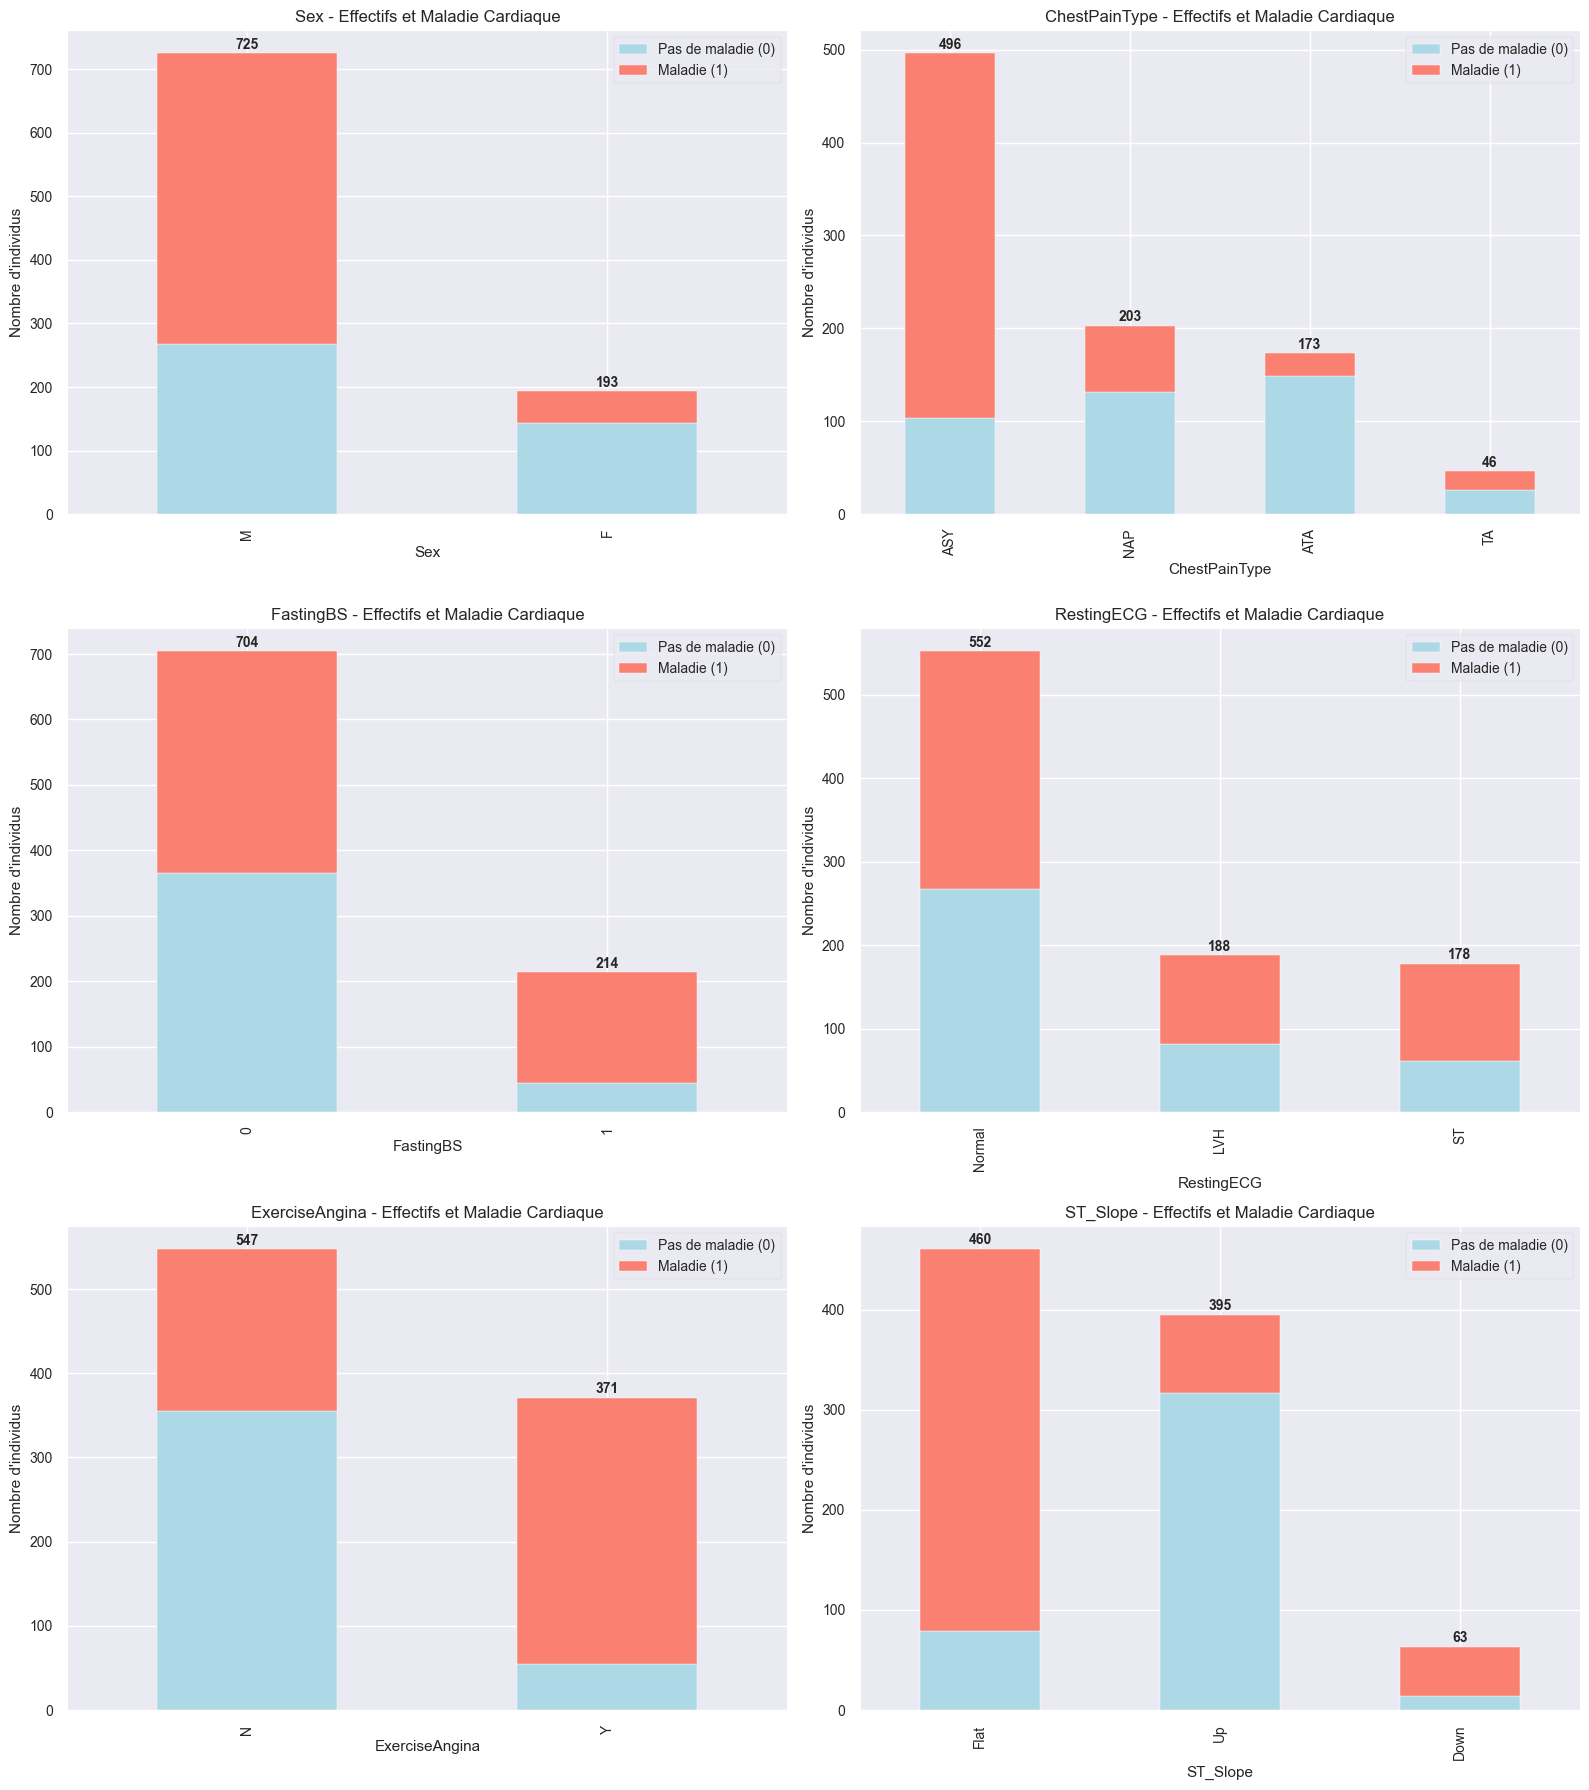

In [8]:
cat_features = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Initialisation de la figure
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

# Parcours de chaque variable catégorielle
for i, feature in enumerate(cat_features):
    # Comptage des occurrences avec le statut de maladie
    crosstab = pd.crosstab(df[feature], df['HeartDisease'])
    
    # Vérification des colonnes pour éviter les erreurs
    if 0 not in crosstab.columns:
        crosstab[0] = 0
    if 1 not in crosstab.columns:
        crosstab[1] = 0
    
    # Création d'une colonne "Total"
    crosstab['Total'] = crosstab.sum(axis=1)
    
    # Plot pondéré par le total
    crosstab = crosstab.sort_values(by='Total', ascending=False)
    crosstab[[0, 1]].plot(kind='bar', stacked=True, ax=axes[i], color=['lightblue', 'salmon'])
    
    # Ajout des effectifs totaux sur chaque barre
    for j, (index, row) in enumerate(crosstab.iterrows()):
        axes[i].text(j, row['Total'] + 2, f"{int(row['Total'])}", ha='center', va='bottom', fontweight='bold')
    
    # Titres et légendes
    axes[i].set_title(f'{feature} - Effectifs et Maladie Cardiaque')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Nombre d\'individus')
    axes[i].legend(['Pas de maladie (0)', 'Maladie (1)'])

plt.tight_layout()
plt.show()

### 1.3 Analyse des  variables numériques

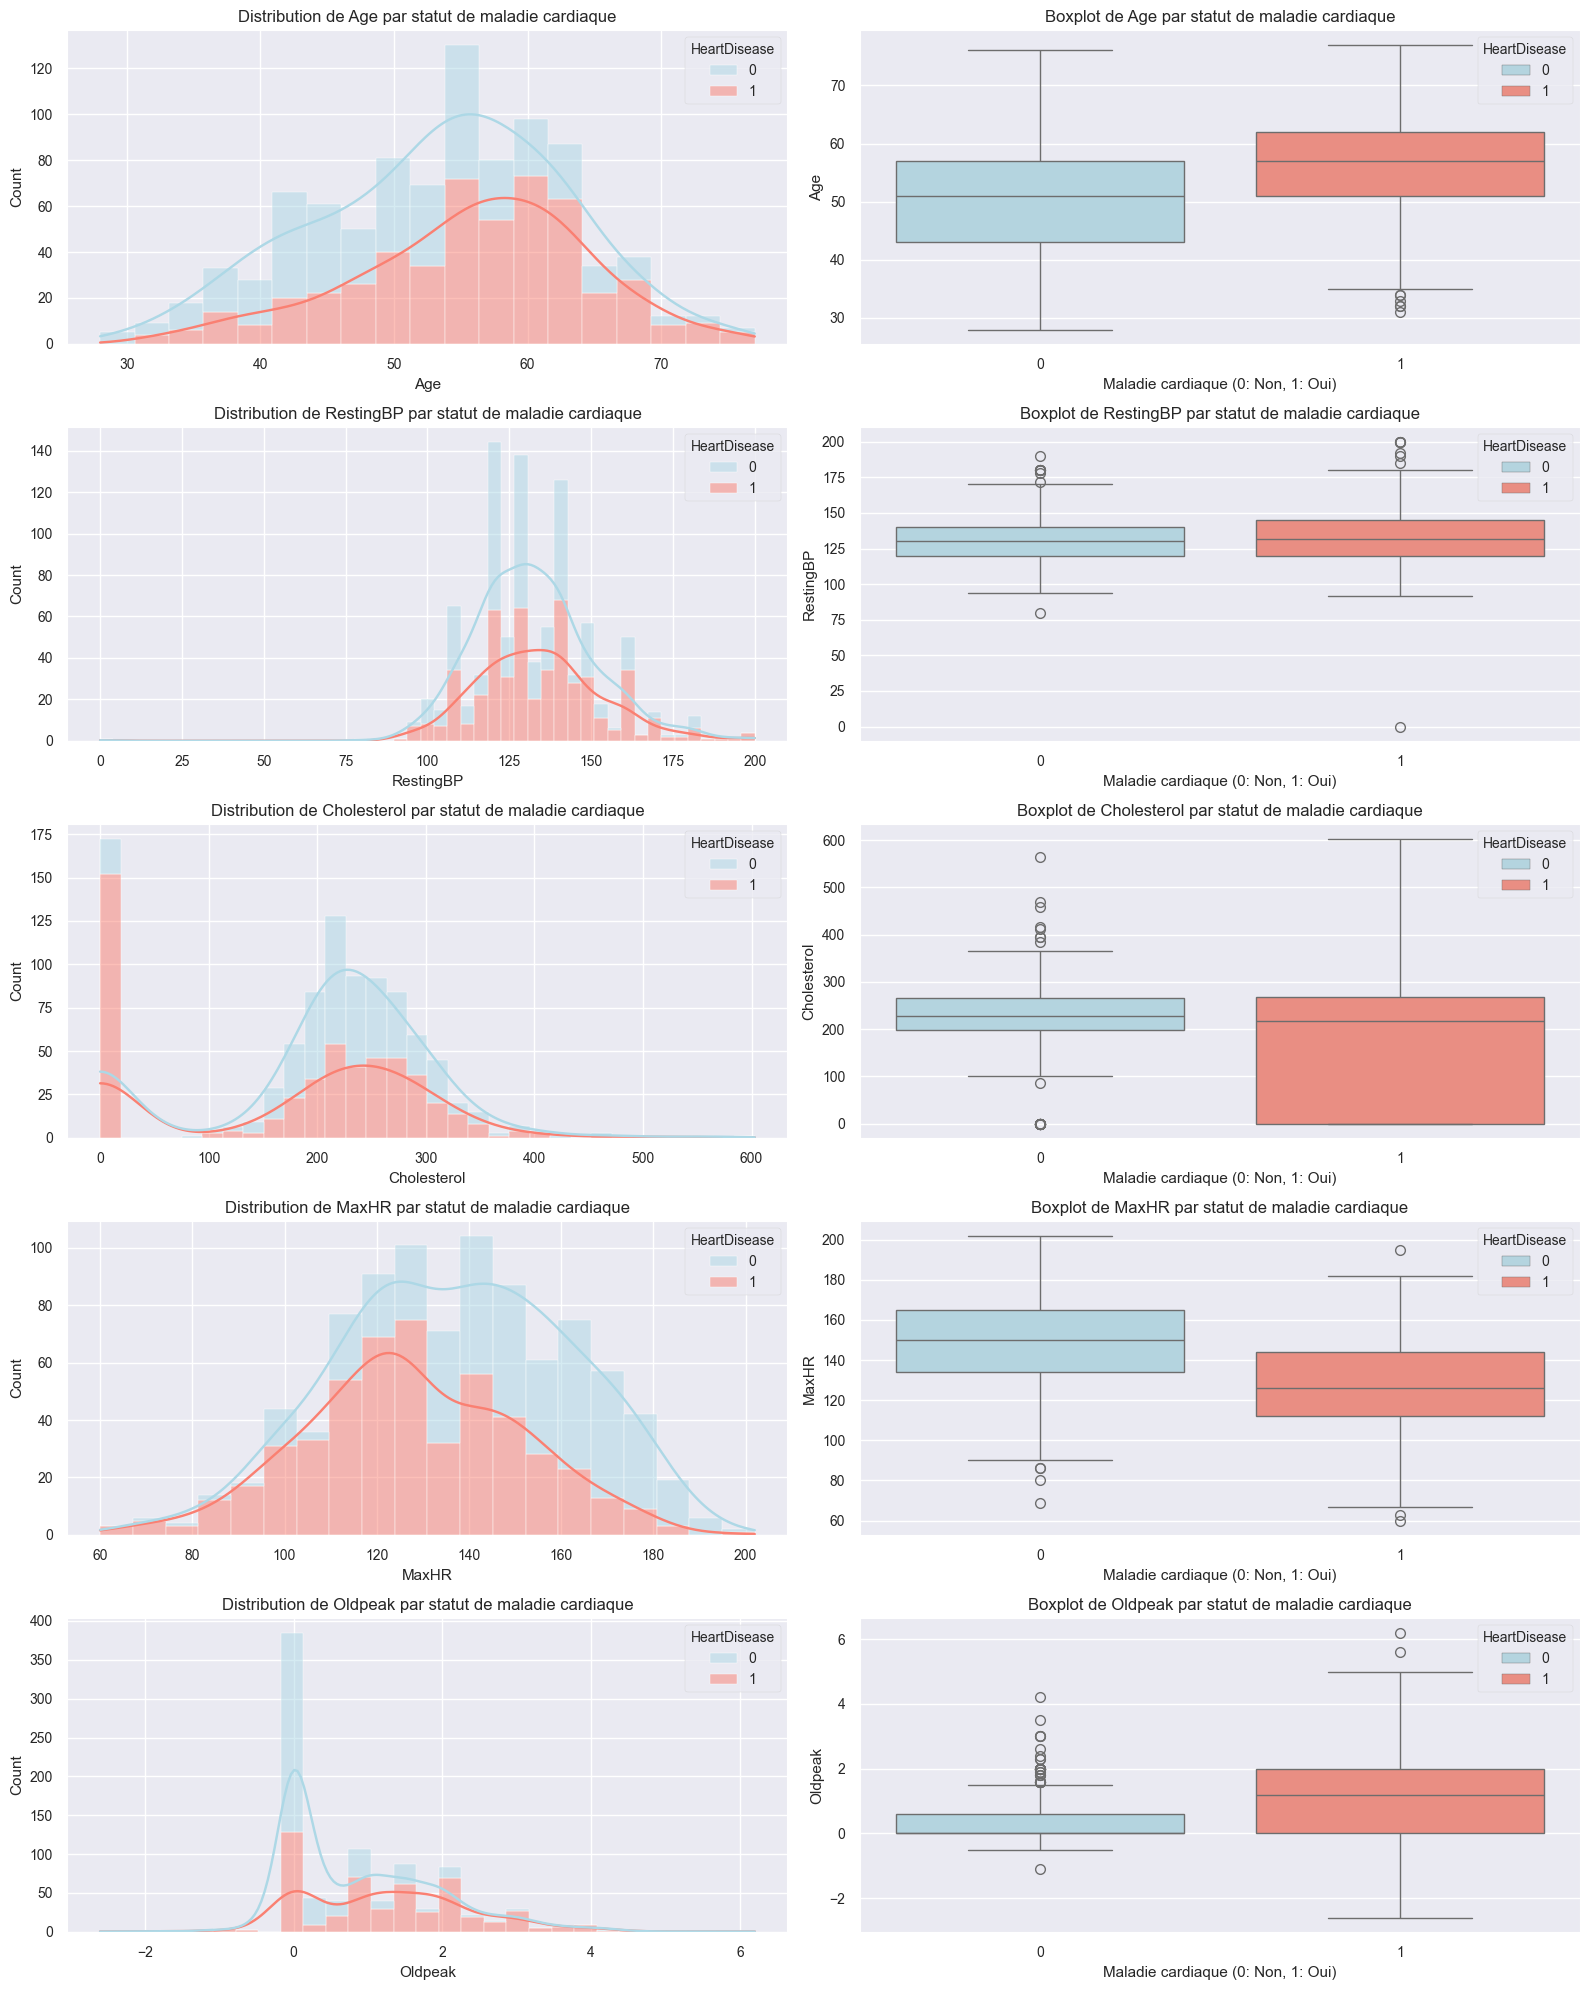

In [9]:
num_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# Distribution de chaque variable numérique segmentée par maladie cardiaque
fig, axes = plt.subplots(len(num_features), 2, figsize=(16, 20))

for i, feature in enumerate(num_features):
    # Histogramme
    sns.histplot(data=df, x=feature, hue='HeartDisease', multiple="stack", 
                 palette=['lightblue', 'salmon'], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribution de {feature} par statut de maladie cardiaque')
    
    # Boxplot
    sns.boxplot(data=df, x='HeartDisease', y=feature, palette=['lightblue', 'salmon'], hue = 'HeartDisease', ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot de {feature} par statut de maladie cardiaque')
    axes[i, 1].set_xlabel('Maladie cardiaque (0: Non, 1: Oui)')

plt.tight_layout()
plt.savefig('images/numerique_plot')

## 2) Corrélations et détermination des variables importantes 

### 2.1) Matrice de corrélation


Construction de la matrice de corrélation mixte...


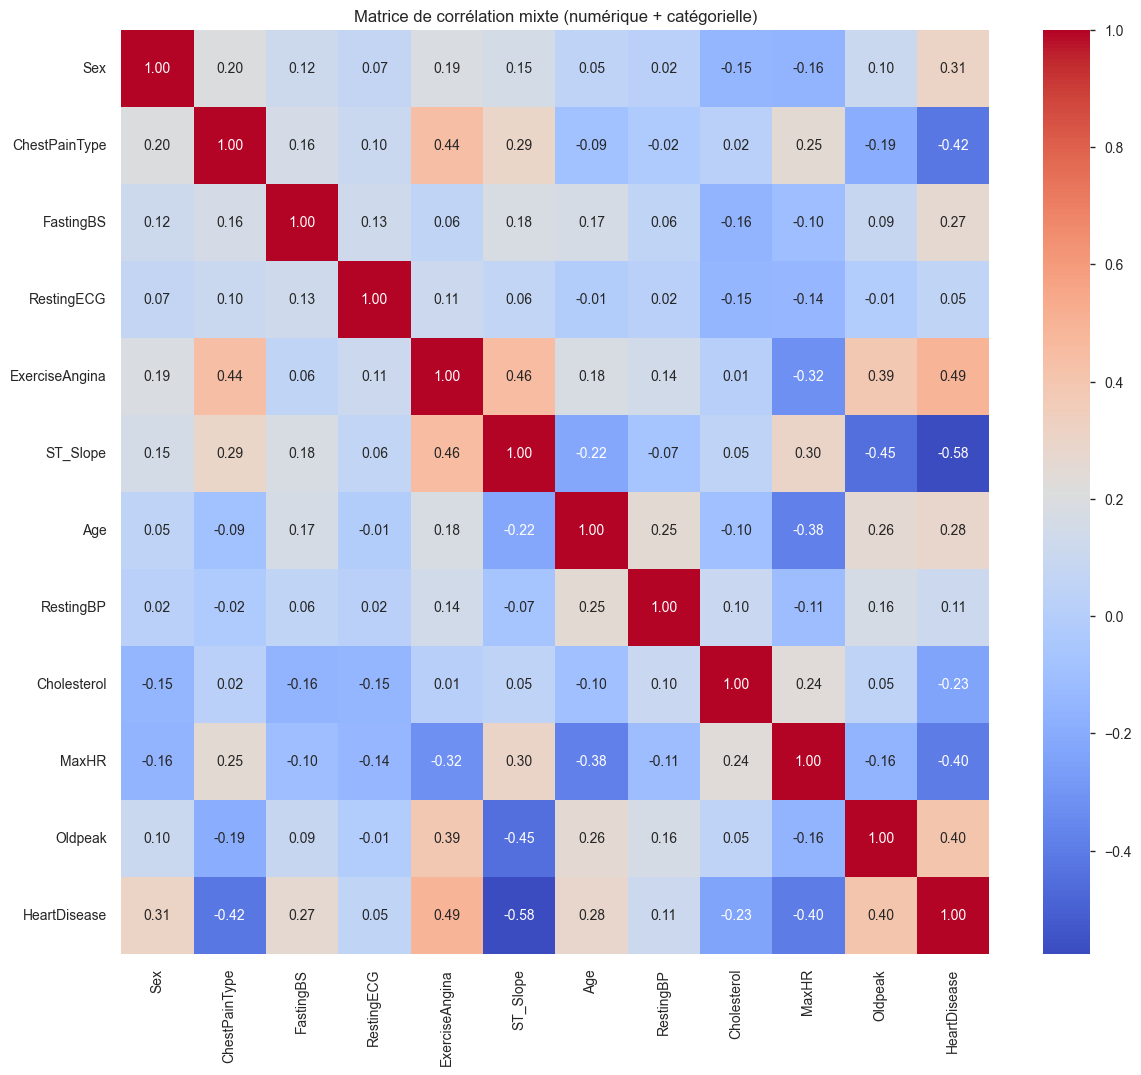

In [10]:
# Fonction pour calculer le coefficient V de Cramér (pour les variables catégorielles)
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k-1, r-1))

# Création d'une matrice de corrélation mixte
corr_matrix = pd.DataFrame(index=cat_features+num_features+['HeartDisease'], 
                           columns=cat_features+num_features+['HeartDisease'])

print("\nConstruction de la matrice de corrélation mixte...")
for var1 in corr_matrix.index:
    for var2 in corr_matrix.columns:
        if var1 in cat_features and var2 in cat_features:
            # Corrélation entre variables catégorielles (V de Cramér)
            corr_matrix.loc[var1,var2] = cramers_v(df[var1], df[var2])
        elif var1 in num_features+['HeartDisease'] and var2 in num_features+['HeartDisease']:
            # Corrélation entre variables numériques (Pearson)
            corr_matrix.loc[var1,var2] = df[var1].corr(df[var2])
        else:
            # Corrélation entre variables numériques et catégorielles (Tau de Kendall)
            if var1 in cat_features and var2 in num_features+['HeartDisease']:
                corr_matrix.loc[var1,var2] = kendalltau(df[var1].astype('category').cat.codes, df[var2])[0]
            else:
                corr_matrix.loc[var1,var2] = kendalltau(df[var2].astype('category').cat.codes, df[var1])[0]

corr_matrix = corr_matrix.astype(float)

# Visualisation de la matrice de corrélation
plt.figure(figsize=(14,12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matrice de corrélation mixte (numérique + catégorielle)")
plt.show()


### 2.1 Analyse des corrélations 


Corrélations avec la variable cible (HeartDisease):
HeartDisease      1.000000
ExerciseAngina    0.494282
Oldpeak           0.403951
Sex               0.305445
Age               0.282039
FastingBS         0.267291
RestingBP         0.107589
RestingECG        0.054409
Cholesterol      -0.232741
MaxHR            -0.400421
ChestPainType    -0.416311
ST_Slope         -0.576033
Name: HeartDisease, dtype: float64


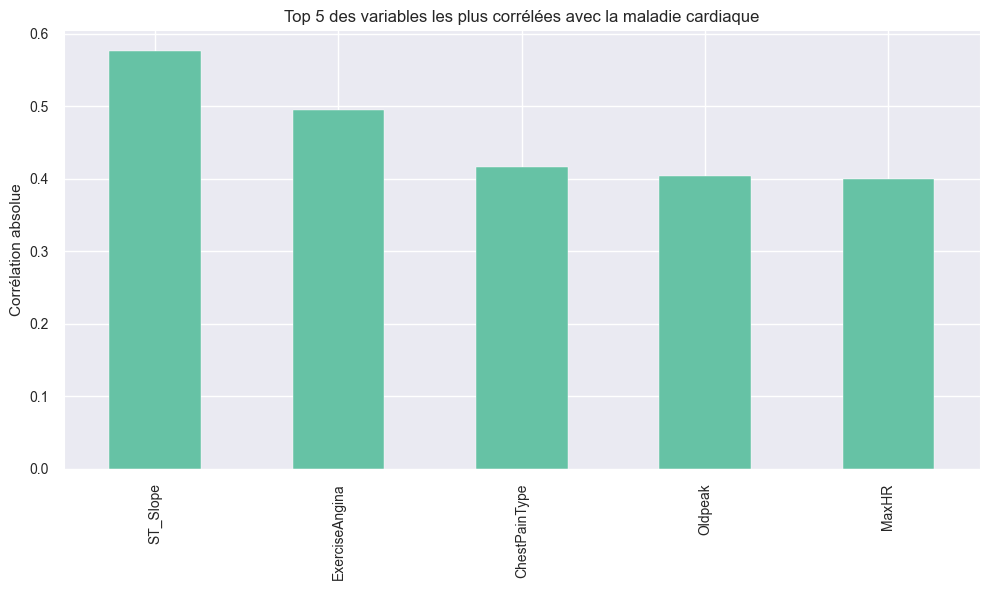

In [11]:
# Corrélations avec la variable cible
target_corr = corr_matrix['HeartDisease'].sort_values(ascending=False)
print("\nCorrélations avec la variable cible (HeartDisease):")
print(target_corr)

# Top 5 des variables les plus corrélées avec la maladie cardiaque
plt.figure(figsize=(10, 6))
target_corr.drop('HeartDisease').abs().sort_values(ascending=False).head(5).plot(kind='bar')
plt.title('Top 5 des variables les plus corrélées avec la maladie cardiaque')
plt.ylabel('Corrélation absolue')
plt.tight_layout()
plt.show()

### 2.2 Identification des variables fortement corrélées entre elles

In [12]:
# On crée une copie de la matrice sans la diagonale pour trouver les corrélations élevées
corr_matrix_no_diag = corr_matrix.copy()
np.fill_diagonal(corr_matrix_no_diag.values, 0)
print("aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa")
print(corr_matrix_no_diag['HeartDisease'])
# Seuil de corrélation élevée
high_corr_threshold = 0.6
high_corr_pairs = []

# Trouver les paires de variables fortement corrélées
for i in range(len(corr_matrix_no_diag.columns)):
    for j in range(i+1, len(corr_matrix_no_diag.columns)):
        if abs(corr_matrix_no_diag.iloc[i, j]) >= high_corr_threshold:
            var1 = corr_matrix_no_diag.index[i]
            var2 = corr_matrix_no_diag.columns[j]
            correlation = corr_matrix_no_diag.iloc[i, j]
            high_corr_pairs.append((var1, var2, correlation))

# Afficher les paires fortement corrélées
if high_corr_pairs:
    print(f"\nVariables fortement corrélées entre elles (|corr| >= {high_corr_threshold}):")
    for var1, var2, corr in high_corr_pairs:
        print(f"- {var1} et {var2}: {corr:.3f}")
else:
    print(f"\nAucune paire de variables fortement corrélées n'a été trouvée (seuil: {high_corr_threshold})")

aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
Sex               0.305445
ChestPainType    -0.416311
FastingBS         0.267291
RestingECG        0.054409
ExerciseAngina    0.494282
ST_Slope         -0.576033
Age               0.282039
RestingBP         0.107589
Cholesterol      -0.232741
MaxHR            -0.400421
Oldpeak           0.403951
HeartDisease      0.000000
Name: HeartDisease, dtype: float64

Aucune paire de variables fortement corrélées n'a été trouvée (seuil: 0.6)


### 2.3 Sélection des variables à conserver en éliminant les redondances

In [13]:
# 1. Sélection des variables corrélées avec HeartDisease
corr_target= 0.3
corr_with_target = corr_matrix['HeartDisease'].drop('HeartDisease').abs()
important_features = corr_with_target[corr_with_target > corr_target].index.tolist()
print(f"\nVariables corrélées avec HeartDisease (|corr| > {corr_target}): {important_features}")

# 2. Élimination des variables redondantes
features_to_remove = set()

for var1, var2, _ in high_corr_pairs:
    # On ne retire les variables que si les deux sont dans les features importantes
    if var1 in important_features and var2 in important_features:
        # On garde celle qui a la plus forte corrélation avec HeartDisease
        if abs(corr_matrix.loc[var1, 'HeartDisease']) >= abs(corr_matrix.loc[var2, 'HeartDisease']):
            features_to_remove.add(var2)
        else:
            features_to_remove.add(var1)

# Variables finales à conserver
final_features = [f for f in df.columns if f != 'HeartDisease' and f not in features_to_remove]
print(f"\nVariables sélectionnées après élimination des redondances: {final_features}")



Variables corrélées avec HeartDisease (|corr| > 0.3): ['Sex', 'ChestPainType', 'ExerciseAngina', 'ST_Slope', 'MaxHR', 'Oldpeak']

Variables sélectionnées après élimination des redondances: ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']



## 3) PRÉPARATION DES DONNÉES POUR LA MODÉLISATION

### 3.1) Séparation des features et de la variable cible

In [14]:
X = df[final_features]  # Utiliser uniquement les variables sélectionnées
y = df['HeartDisease']

### 3.2. Identification des types de variables

In [15]:
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("\nVariables catégorielles sélectionnées:", categorical_features)
print("Variables numériques sélectionnées:", numerical_features)

# Variables ordinales avec ordre naturel
st_slope_categories = ['Up', 'Flat', 'Down']
ordinal_features = ['ST_Slope'] if 'ST_Slope' in categorical_features else []

# Séparation des variables catégorielles sans ordre et avec ordre
categorical_no_order = [feat for feat in categorical_features if feat not in ordinal_features]

# 3. DIVISION DES DONNÉES EN ENSEMBLES D'ENTRAÎNEMENT ET DE TEST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)



Variables catégorielles sélectionnées: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
Variables numériques sélectionnées: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']


### 3.3) Préparation du pipeline de traitement

In [16]:
#Pipeline pour les variables catégorielles sans ordre (one-hot encoding)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

# Pipeline pour les variables ordinales (ST_Slope)
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=[st_slope_categories]))
]) if ordinal_features else None

# Pipeline pour les variables numériques avec KNNImputer et normalisation
numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())  # Standardisation des variables numériques
])

# Création de la liste des transformateurs
transformers = [
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_no_order)
]

# Ajouter le transformateur ordinal s'il y a des variables ordinales
if ordinal_features:
    transformers.append(('ord', ordinal_transformer, ordinal_features))

# Assemblage des transformations avec ColumnTransformer
preprocessor = ColumnTransformer(transformers=transformers)

### 3.4) APPLICATION DU PRÉTRAITEMENT

In [17]:

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Récupération des noms des colonnes après transformation
transformed_feature_names = []

# Ajout des colonnes numériques (gardent le même nom)
transformed_feature_names.extend(numerical_features)

# Ajout des colonnes catégorielles avec one-hot encoding
if categorical_no_order:
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    for i, feat_name in enumerate(categorical_no_order):
        categories = ohe.categories_[i][1:]  # drop='first' donc on commence à l'indice 1
        for category in categories:
            transformed_feature_names.append(f"{feat_name}_{category}")

# Ajout des colonnes ordinales (gardent le même nom)
if ordinal_features:
    transformed_feature_names.extend(ordinal_features)

print("\nNoms des colonnes après transformation:", transformed_feature_names)

# Création d'un DataFrame avec les données transformées pour inspection
X_train_df = pd.DataFrame(X_train_transformed, columns=transformed_feature_names)
print("\nAperçu du DataFrame après transformation:")
print(X_train_df.head())

# Statistiques du DataFrame transformé
print("\nStatistiques descriptives du DataFrame transformé:")
print(X_train_df.describe())


Noms des colonnes après transformation: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_M', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_Y', 'ST_Slope']

Aperçu du DataFrame après transformation:
        Age  RestingBP  Cholesterol  FastingBS     MaxHR   Oldpeak  Sex_M  \
0 -1.148633  -0.975836     0.931322  -0.543754  1.721816  0.304911    1.0   
1  2.328972  -1.578851    -0.826767  -0.543754 -0.623108  2.455047    1.0   
2  0.221333  -0.263182     0.191074  -0.543754 -0.661549  1.052784    1.0   
3  0.853625   0.120555    -0.586187  -0.543754  0.030396 -0.629931    1.0   
4  0.748243  -0.701738     0.533439  -0.543754  0.145720  2.548531    1.0   

   ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  RestingECG_Normal  \
0                0.0                0.0               0.0                1.0   
1                0.0                1.0               0.0                0.0   
2  

## 4. Recherche du meilleur K

In [18]:
# Évaluation pour différentes valeurs de k (accuracy et f1-score)
k_values = range(1, 31, 2)  # k impairs de 1 à 29
accuracies = []
f1_scores = []

print("\nRecherche du meilleur k pour KNN...")
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_results = cross_val_score(knn, X_train_transformed, y_train, cv=5, scoring='accuracy')
    accuracies.append(cv_results.mean())
    
    cv_results_f1 = cross_val_score(knn, X_train_transformed, y_train, cv=5, scoring='f1')
    f1_scores.append(cv_results_f1.mean())
    print(f"k={k}: Accuracy={cv_results.mean():.4f}, F1-score={cv_results_f1.mean():.4f}")

# Afficher le k optimal selon les deux métriques
best_k_accuracy = k_values[np.argmax(accuracies)]
best_k_f1 = k_values[np.argmax(f1_scores)]

print(f"\nMeilleur k pour l'accuracy: {best_k_accuracy} (accuracy: {max(accuracies):.4f})")
print(f"Meilleur k pour le F1-score: {best_k_f1} (F1-score: {max(f1_scores):.4f})")

# Validation avec GridSearchCV pour une recherche plus exhaustive
param_grid = {'n_neighbors': range(1, 31, 2)}
knn = KNeighborsClassifier()

# GridSearch avec F1-score comme métrique
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_transformed, y_train)

best_k_grid = grid_search.best_params_['n_neighbors']
print(f"\nMeilleur k selon GridSearchCV: {best_k_grid}")
print(f"Meilleur F1-score CV: {grid_search.best_score_:.4f}")

# On utilise le meilleur k trouvé par GridSearchCV
best_k = best_k_grid


Recherche du meilleur k pour KNN...
k=1: Accuracy=0.7965, F1-score=0.8170
k=3: Accuracy=0.8154, F1-score=0.8356
k=5: Accuracy=0.8212, F1-score=0.8426
k=7: Accuracy=0.8343, F1-score=0.8541
k=9: Accuracy=0.8255, F1-score=0.8455
k=11: Accuracy=0.8270, F1-score=0.8474
k=13: Accuracy=0.8357, F1-score=0.8554
k=15: Accuracy=0.8358, F1-score=0.8550
k=17: Accuracy=0.8343, F1-score=0.8535
k=19: Accuracy=0.8270, F1-score=0.8476
k=21: Accuracy=0.8270, F1-score=0.8469
k=23: Accuracy=0.8343, F1-score=0.8524
k=25: Accuracy=0.8343, F1-score=0.8524
k=27: Accuracy=0.8285, F1-score=0.8472
k=29: Accuracy=0.8329, F1-score=0.8504

Meilleur k pour l'accuracy: 15 (accuracy: 0.8358)
Meilleur k pour le F1-score: 13 (F1-score: 0.8554)

Meilleur k selon GridSearchCV: 13
Meilleur F1-score CV: 0.8554


### 5. ENTRAÎNEMENT ET ÉVALUATION DU MODÈLE KNN

In [19]:
# Modèle KNN avec le meilleur k
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_transformed, y_train)

# Prédictions
y_pred_knn = best_knn.predict(X_test_transformed)
y_prob_knn = best_knn.predict_proba(X_test_transformed)[:, 1]

# Évaluation du modèle
print("\nÉvaluation du modèle KNN:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_knn):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob_knn):.4f}")

print("\nRapport de classification KNN:\n", classification_report(y_test, y_pred_knn))


Évaluation du modèle KNN:
Accuracy: 0.8826
F1-score: 0.8949
AUC-ROC: 0.9419

Rapport de classification KNN:
               precision    recall  f1-score   support

           0       0.88      0.85      0.87       103
           1       0.88      0.91      0.89       127

    accuracy                           0.88       230
   macro avg       0.88      0.88      0.88       230
weighted avg       0.88      0.88      0.88       230



### 6. IMPLÉMENTATION DU MODÈLE XGBOOST en prenant en compte les variables catégorielles

In [20]:
# 1. Prétraitement pour XGBoost avec support des catégories
preprocessor_xgb = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', KNNImputer(n_neighbors=5))
        ]), numerical_features),
        ('cat', 'passthrough', categorical_features)
    ],
    remainder='drop',
    verbose_feature_names_out=False  # Pour garder les noms de colonnes originaux
)

# Prétraitement des données
X_train_xgb_array = preprocessor_xgb.fit_transform(X_train)
X_test_xgb_array = preprocessor_xgb.transform(X_test)

# Récupération des noms de colonnes
output_columns = numerical_features + categorical_features

# Création des DataFrames avec types appropriés
X_train_xgb = pd.DataFrame(X_train_xgb_array, columns=output_columns)
X_test_xgb = pd.DataFrame(X_test_xgb_array, columns=output_columns)

# Conversion des types de colonnes 
for col in numerical_features:
    X_train_xgb[col] = pd.to_numeric(X_train_xgb[col])
    X_test_xgb[col] = pd.to_numeric(X_test_xgb[col])

for col in categorical_features:
    X_train_xgb[col] = X_train_xgb[col].astype('category')
    X_test_xgb[col] = X_test_xgb[col].astype('category')

# Vérification des types de données
print("Types de données du DataFrame d'entraînement:")
print(X_train_xgb.dtypes)

# Modèle XGBoost avec support natif des catégories
xgb_model = xgb.XGBClassifier(
    tree_method='hist',       # 'hist' est recommandé pour les catégories
    enable_categorical=True,  # Activer le support des catégories
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42
)

# Entraînement du modèle
xgb_model.fit(X_train_xgb, y_train)

# Prédictions
y_pred_xgb = xgb_model.predict(X_test_xgb)
y_prob_xgb = xgb_model.predict_proba(X_test_xgb)[:, 1]

# Évaluation du modèle XGBoost
print("\nÉvaluation du modèle XGBoost (sans opti):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_xgb):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob_xgb):.4f}")

print("\nRapport de classification XGBoost (sans opti):\n", classification_report(y_test, y_pred_xgb))

# Matrice de confusion pour XGBoost 
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
tn, fp, fn, tp = cm_xgb.ravel()
print(f"\nMatrice de confusion XGBoost :")
print(f"Vrais Négatifs (TN): {tn}")
print(f"Faux Positifs (FP): {fp}")
print(f"Faux Négatifs (FN): {fn}")
print(f"Vrais Positifs (TP): {tp}")
print(f"Taux de faux négatifs: {fn/(fn+tp):.4f} ({fn} sur {fn+tp} cas positifs)")

Types de données du DataFrame d'entraînement:
Age                float64
RestingBP          float64
Cholesterol        float64
FastingBS          float64
MaxHR              float64
Oldpeak            float64
Sex               category
ChestPainType     category
RestingECG        category
ExerciseAngina    category
ST_Slope          category
dtype: object

Évaluation du modèle XGBoost (sans opti):
Accuracy: 0.8913
F1-score: 0.8996
AUC-ROC: 0.9352

Rapport de classification XGBoost (sans opti):
               precision    recall  f1-score   support

           0       0.86      0.90      0.88       103
           1       0.92      0.88      0.90       127

    accuracy                           0.89       230
   macro avg       0.89      0.89      0.89       230
weighted avg       0.89      0.89      0.89       230


Matrice de confusion XGBoost :
Vrais Négatifs (TN): 93
Faux Positifs (FP): 10
Faux Négatifs (FN): 15
Vrais Positifs (TP): 112
Taux de faux négatifs: 0.1181 (15 sur 127 cas p

## 7) Feature engineering

### 7.1) Ajouts de features

In [21]:
# Ajout de features d'interaction dans le dataset original
X_train_fe = X_train.copy()
X_test_fe = X_test.copy()

# Conversion des variables catégorielles pour les calculs
for col in categorical_features:
    encoder = OrdinalEncoder()
    X_train_fe[col] = encoder.fit_transform(X_train_fe[[col]])
    X_test_fe[col] = encoder.transform(X_test_fe[[col]])

# Imputation des valeurs manquantes si nécessaire
imputer = KNNImputer(n_neighbors=5)
X_train_fe = pd.DataFrame(imputer.fit_transform(X_train_fe), columns=X_train_fe.columns)
X_test_fe = pd.DataFrame(imputer.transform(X_test_fe), columns=X_test_fe.columns)

# Création de nouvelles features d'interaction
# Age * Cholesterol (interaction physiologique entre l'âge et le cholestérol)
X_train_fe['Age_Chol'] = X_train_fe['Age'] * X_train_fe['Cholesterol'] / 100
X_test_fe['Age_Chol'] = X_test_fe['Age'] * X_test_fe['Cholesterol'] / 100

# MaxHR / Age (rapport important en cardiologie)
X_train_fe['MaxHR_Age_Ratio'] = X_train_fe['MaxHR'] / X_train_fe['Age']
X_test_fe['MaxHR_Age_Ratio'] = X_test_fe['MaxHR'] / X_test_fe['Age']

# RestingBP * Oldpeak (interaction entre pression et dépression ST)
X_train_fe['BP_ST_Depression'] = X_train_fe['RestingBP'] * (X_train_fe['Oldpeak'] + 1)
X_test_fe['BP_ST_Depression'] = X_test_fe['RestingBP'] * (X_test_fe['Oldpeak'] + 1)

# Indice de stress cardiaque combiné
X_train_fe['Cardiac_Stress_Index'] = X_train_fe['RestingBP'] / X_train_fe['MaxHR'] * X_train_fe['Age'] / 50
X_test_fe['Cardiac_Stress_Index'] = X_test_fe['RestingBP'] / X_test_fe['MaxHR'] * X_test_fe['Age'] / 50

# Transformation logarithmique du cholestérol pour normaliser sa distribution
X_train_fe['Log_Cholesterol'] = np.log1p(X_train_fe['Cholesterol'])
X_test_fe['Log_Cholesterol'] = np.log1p(X_test_fe['Cholesterol'])

# Normaliser les features numériques pour améliorer la performance des modèles
numerical_features = X_train_fe.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X_train_fe[numerical_features] = scaler.fit_transform(X_train_fe[numerical_features])
X_test_fe[numerical_features] = scaler.transform(X_test_fe[numerical_features])

#Application de techniques de rééchantillonnage pour équilibrer les classes
print("\nApplication de techniques de rééchantillonnage:")

# SMOTE pour surreprésenter la classe minoritaire (maladies cardiaques)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_fe, y_train)

# Combinaison de SMOTE et ENN pour un nettoyage des frontières de décision
smoteenn = SMOTEENN(random_state=42)
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train_fe, y_train)

# Combinaison de SMOTE et Tomek links
smotetomek = SMOTETomek(random_state=42)
X_train_smotetomek, y_train_smotetomek = smotetomek.fit_resample(X_train_fe, y_train)


Application de techniques de rééchantillonnage:


### 7.2)Résultat du feature engineering

Distribution originale: [307 381]
Distribution après SMOTE: [381 381]
Distribution après SMOTE-ENN: [267 245]
Distribution après SMOTE-Tomek: [357 357]


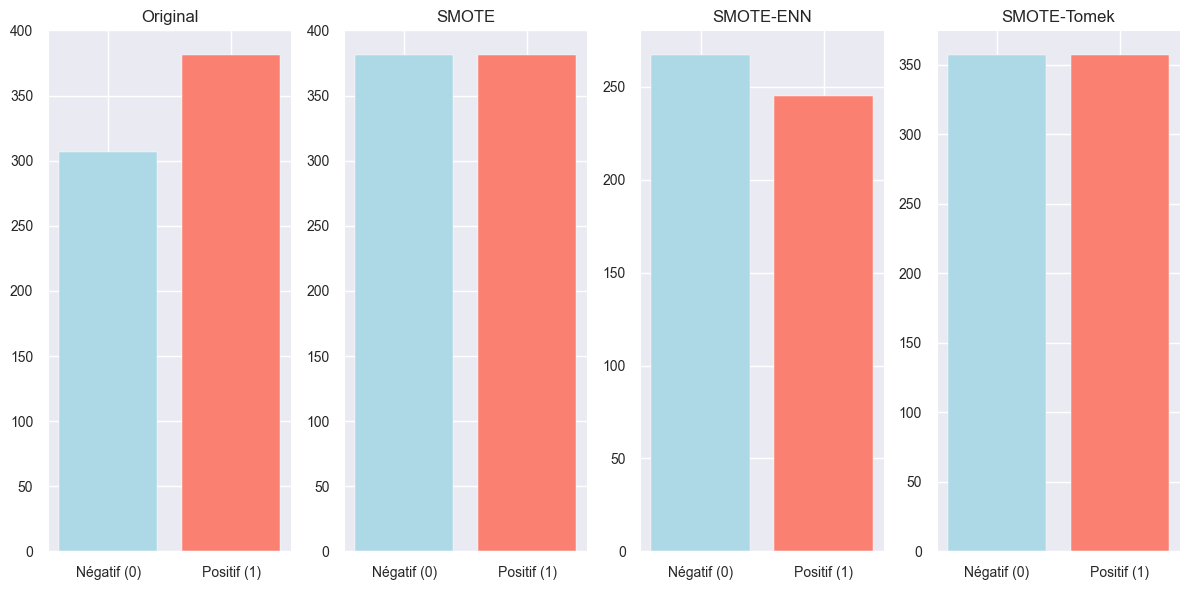

In [22]:
# Affichage des distributions après rééchantillonnage
print(f"Distribution originale: {np.bincount(y_train)}")
print(f"Distribution après SMOTE: {np.bincount(y_train_smote)}")
print(f"Distribution après SMOTE-ENN: {np.bincount(y_train_smoteenn)}")
print(f"Distribution après SMOTE-Tomek: {np.bincount(y_train_smotetomek)}")

# Visualisation des distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.bar(['Négatif (0)', 'Positif (1)'], np.bincount(y_train), color=['lightblue', 'salmon'])
plt.title('Original')

plt.subplot(1, 4, 2)
plt.bar(['Négatif (0)', 'Positif (1)'], np.bincount(y_train_smote), color=['lightblue', 'salmon'])
plt.title('SMOTE')

plt.subplot(1, 4, 3)
plt.bar(['Négatif (0)', 'Positif (1)'], np.bincount(y_train_smoteenn), color=['lightblue', 'salmon'])
plt.title('SMOTE-ENN')

plt.subplot(1, 4, 4)
plt.bar(['Négatif (0)', 'Positif (1)'], np.bincount(y_train_smotetomek), color=['lightblue', 'salmon'])
plt.title('SMOTE-Tomek')

plt.tight_layout()
plt.show()


## 8) AMÉLIORATION DU MODÈLE XGBOOST

### 8.1 Recherche RandomizedSearchCV plus étendue pour les hyperparamètres de XGBoost 

In [23]:
print("\nOptimisation avancée des hyperparamètres de XGBoost...")

# Définition de l'espace de recherche des hyperparamètres plus large
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 2, 3, 4, 5],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'scale_pos_weight': [1, 2, 3, 5]  # Donner plus de poids aux cas positifs
}

# Initialisation du modèle XGBoost de base
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    enable_categorical=True,
    random_state=42,
)

# Validation croisée stratifiée pour maintenir la distribution des classes
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Définir une fonction de score personnalisée qui pénalise davantage les faux négatifs
def custom_scorer(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Pénalité plus forte pour les faux négatifs (coefficient 2)
    weighted_error = (fp + 2*fn) / (tn + fp + 2*fn + tp)
    return 1 - weighted_error

scorer = make_scorer(custom_scorer, greater_is_better=True)

# RandomizedSearchCV pour chercher efficacement dans l'espace des hyperparamètres
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1',  # On peut aussi utiliser scorer pour un score personnalisé
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Entrainement sur les données avec SMOTE (meilleur équilibrage)
random_search.fit(X_train_smote, y_train_smote)

# Affichage des meilleurs paramètres trouvés
print(f"Meilleurs paramètres RandomizedSearchCV: {random_search.best_params_}")
print(f"Meilleur score F1 (CV): {random_search.best_score_:.4f}")

# Sauvegarder les meilleurs paramètres pour une utilisation ultérieure
best_params = random_search.best_params_


Optimisation avancée des hyperparamètres de XGBoost...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Meilleurs paramètres RandomizedSearchCV: {'subsample': 1.0, 'scale_pos_weight': 2, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.4, 'colsample_bytree': 0.6, 'colsample_bylevel': 1.0}
Meilleur score F1 (CV): 0.8720


### 8.2) Entraînement du modèle final avec early stopping adapté 

In [24]:
# Vérification de l'alignement des indices
# Réinitialisation 
X_train_smote = X_train_smote.reset_index(drop=True)
y_train_smote = y_train_smote.reset_index(drop=True)
X_test_fe = X_test_fe.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print("\nEntraînement du modèle XGBoost optimisé avec early stopping...")

# Création d'un ensemble de validation pour l'early stopping
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train_smote, y_train_smote, test_size=0.2, random_state=42, stratify=y_train_smote
)

# Initialisation du modèle XGBoost final avec les meilleurs paramètres
xgb_optimized = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric=['auc', 'logloss'],
    **best_params,
    random_state=42,
    early_stopping_rounds=20,
    enable_categorical=True
)

# Entraînement avec early stopping pour éviter le surapprentissage
eval_set = [(X_train_sub, y_train_sub), (X_val, y_val)]
xgb_optimized.fit(
    X_train_sub, y_train_sub,
    eval_set=eval_set,
    verbose=True
)

y_pred_xgb_optimized = xgb_optimized.predict(X_test_fe)  # Nouveau modèle optimisé sur les features enrichies
y_prob_xgb_optimized = xgb_optimized.predict_proba(X_test_fe)[:, 1]

# Évaluation complète des modèles
def evaluate_model(y_true, y_pred, y_prob, model_name):
    """Évalue un modèle de classification binaire avec des métriques diverses"""
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # Taux de faux négatifs (crucial en médecine)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # Taux de faux positifs
    
    # Afficher les métriques
    print(f"\nÉvaluation du modèle {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensibilité): {recall:.4f}")
    print(f"Spécificité: {tn/(tn+fp):.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print(f"Taux de faux négatifs: {fnr:.4f}")
    print(f"Taux de faux positifs: {fpr:.4f}")
    
    print("\nMatrice de confusion:")
    print(f"[[{tn} {fp}]")
    print(f" [{fn} {tp}]]")
    
    # Calculer l'intervalle de confiance à 95% pour l'AUC-ROC
    n_bootstraps = 1000
    bootstrapped_scores = []
    
    # Bootstrapping pour l'intervalle de confiance
    rng = np.random.RandomState(42)
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[indices])) < 2:
            # Skip this bootstrap if only one class is present
            continue
        bootstrapped_scores.append(roc_auc_score(y_true[indices], y_prob[indices]))
        
    # Calculer l'intervalle de confiance à 95%
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    
    print(f"Intervalle de confiance à 95% pour AUC-ROC: [{confidence_lower:.4f}, {confidence_upper:.4f}]")
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'roc_auc': roc_auc,
        'precision': precision,
        'recall': recall,
        'specificity': tn/(tn+fp),
        'fnr': fnr,
        'fpr': fpr,
        'confusion_matrix': cm,
        'auc_ci': (confidence_lower, confidence_upper)
    }

# Évaluation des modèles
results_baseline = evaluate_model(y_test, y_pred_xgb, y_prob_xgb, "XGBoost Baseline")
results_optimized = evaluate_model(y_test, y_pred_xgb_optimized, y_prob_xgb_optimized, "XGBoost Optimisé")

# Sauvegarder les matrices de confusion pour la visualisation
cm_xgb_baseline = results_baseline['confusion_matrix']
cm_xgb_optimized = results_optimized['confusion_matrix']


Entraînement du modèle XGBoost optimisé avec early stopping...
[0]	validation_0-auc:0.92515	validation_0-logloss:0.74057	validation_1-auc:0.94130	validation_1-logloss:0.74308
[1]	validation_0-auc:0.95528	validation_0-logloss:0.73367	validation_1-auc:0.94361	validation_1-logloss:0.73690
[2]	validation_0-auc:0.96128	validation_0-logloss:0.72805	validation_1-auc:0.94660	validation_1-logloss:0.73185
[3]	validation_0-auc:0.96173	validation_0-logloss:0.72133	validation_1-auc:0.94592	validation_1-logloss:0.72528
[4]	validation_0-auc:0.96097	validation_0-logloss:0.71481	validation_1-auc:0.94968	validation_1-logloss:0.71858
[5]	validation_0-auc:0.95980	validation_0-logloss:0.70850	validation_1-auc:0.94891	validation_1-logloss:0.71244
[6]	validation_0-auc:0.96343	validation_0-logloss:0.70380	validation_1-auc:0.95241	validation_1-logloss:0.70805
[7]	validation_0-auc:0.96522	validation_0-logloss:0.69759	validation_1-auc:0.95190	validation_1-logloss:0.70214
[8]	validation_0-auc:0.96547	validation_

## 9 ANALYSE PAR SEXE

In [25]:
# Récupérer le sexe depuis le jeu de données initial
test_indices = y_test.index
sex_in_test = df.loc[test_indices, 'Sex']

# Créer un DataFrame avec les résultats de prédiction et le sexe
results_df = pd.DataFrame({
    'Sex': sex_in_test,
    'TrueLabel': y_test,
    'Predicted_Baseline': y_pred_xgb,
    'Predicted_Optimized': y_pred_xgb_optimized,
    'Prob_Baseline': y_prob_xgb,
    'Prob_Optimized': y_prob_xgb_optimized
})

# Analyse des performances par sexe
def analyze_by_sex(results_df, model_suffix):
    """Analyser les performances d'un modèle par sexe"""
    male_results = results_df[results_df['Sex'] == 'M']
    female_results = results_df[results_df['Sex'] == 'F']
    
    # Calculer les métriques pour chaque sexe
    pred_col = f'Predicted_{model_suffix}'
    prob_col = f'Prob_{model_suffix}'
    
    # Hommes
    male_metrics = {
        'accuracy': accuracy_score(male_results['TrueLabel'], male_results[pred_col]),
        'f1': f1_score(male_results['TrueLabel'], male_results[pred_col]),
        'auc': roc_auc_score(male_results['TrueLabel'], male_results[prob_col]),
        'recall': recall_score(male_results['TrueLabel'], male_results[pred_col])
    }
    
    male_cm = confusion_matrix(male_results['TrueLabel'], male_results[pred_col])
    tn_m, fp_m, fn_m, tp_m = male_cm.ravel()
    male_metrics['fnr'] = fn_m / (fn_m + tp_m) if (fn_m + tp_m) > 0 else 0
    male_metrics['specificity'] = tn_m / (tn_m + fp_m) if (tn_m + fp_m) > 0 else 0
    
    # Femmes
    female_metrics = {
        'accuracy': accuracy_score(female_results['TrueLabel'], female_results[pred_col]),
        'f1': f1_score(female_results['TrueLabel'], female_results[pred_col]),
        'auc': roc_auc_score(female_results['TrueLabel'], female_results[prob_col]),
        'recall': recall_score(female_results['TrueLabel'], female_results[pred_col])
    }
    
    female_cm = confusion_matrix(female_results['TrueLabel'], female_results[pred_col])
    tn_f, fp_f, fn_f, tp_f = female_cm.ravel()
    female_metrics['fnr'] = fn_f / (fn_f + tp_f) if (fn_f + tp_f) > 0 else 0
    female_metrics['specificity'] = tn_f / (tn_f + fp_f) if (tn_f + fp_f) > 0 else 0
    
    return {
        'male': male_metrics, 
        'female': female_metrics,
        'male_cm': male_cm,
        'female_cm': female_cm,
        'male_count': len(male_results),
        'female_count': len(female_results)
    }

# Analyser les deux modèles
sex_results_baseline = analyze_by_sex(results_df, 'Baseline')
sex_results_optimized = analyze_by_sex(results_df, 'Optimized')

# Afficher les résultats par sexe
print("\nPerformances du modèle par sexe:")
print("\nModèle de base:")
print(f"Hommes (n={sex_results_baseline['male_count']}) - Accuracy: {sex_results_baseline['male']['accuracy']:.4f}, "
      f"F1-score: {sex_results_baseline['male']['f1']:.4f}, "
      f"AUC: {sex_results_baseline['male']['auc']:.4f}, "
      f"FNR: {sex_results_baseline['male']['fnr']:.4f}")
print(f"Femmes (n={sex_results_baseline['female_count']}) - Accuracy: {sex_results_baseline['female']['accuracy']:.4f}, "
      f"F1-score: {sex_results_baseline['female']['f1']:.4f}, "
      f"AUC: {sex_results_baseline['female']['auc']:.4f}, "
      f"FNR: {sex_results_baseline['female']['fnr']:.4f}")

print("\nModèle optimisé:")
print(f"Hommes (n={sex_results_optimized['male_count']}) - Accuracy: {sex_results_optimized['male']['accuracy']:.4f}, "
      f"F1-score: {sex_results_optimized['male']['f1']:.4f}, "
      f"AUC: {sex_results_optimized['male']['auc']:.4f}, "
      f"FNR: {sex_results_optimized['male']['fnr']:.4f}")
print(f"Femmes (n={sex_results_optimized['female_count']}) - Accuracy: {sex_results_optimized['female']['accuracy']:.4f}, "
      f"F1-score: {sex_results_optimized['female']['f1']:.4f}, "
      f"AUC: {sex_results_optimized['female']['auc']:.4f}, "
      f"FNR: {sex_results_optimized['female']['fnr']:.4f}")


Performances du modèle par sexe:

Modèle de base:
Hommes (n=168) - Accuracy: 0.9048, F1-score: 0.9149, AUC: 0.9430, FNR: 0.0947
Femmes (n=62) - Accuracy: 0.8548, F1-score: 0.8525, AUC: 0.9177, FNR: 0.1875

Modèle optimisé:
Hommes (n=168) - Accuracy: 0.9048, F1-score: 0.9184, AUC: 0.9475, FNR: 0.0526
Femmes (n=62) - Accuracy: 0.8226, F1-score: 0.8308, AUC: 0.9052, FNR: 0.1562


### 9.2) Tests

In [26]:
# Test statistique pour comparer les distributions de probabilités entre hommes et femmes
male_probs = results_df[results_df['Sex'] == 'M']['Prob_Optimized']
female_probs = results_df[results_df['Sex'] == 'F']['Prob_Optimized']

# Test de Mann-Whitney U pour comparer les distributions sans hypothèse de normalité
u_stat, p_value = mannwhitneyu(male_probs, female_probs)
print(f"\nTest statistique de Mann-Whitney U pour comparer les probabilités entre hommes et femmes:")
print(f"Statistique U: {u_stat}, p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Différence statistiquement significative dans les probabilités prédites entre hommes et femmes")
else:
    print("Pas de différence statistiquement significative dans les probabilités prédites entre hommes et femmes")

# Test de McNemar pour comparer les performances entre les deux modèles
# Ce test est adapté pour comparer deux modèles sur le même ensemble de test
contingency_table = np.zeros((2, 2), dtype=int)
# [0,0]: les deux modèles ont tort
# [0,1]: modèle de base a tort, modèle optimisé a raison
# [1,0]: modèle de base a raison, modèle optimisé a tort
# [1,1]: les deux modèles ont raison

for i in range(len(y_test)):
    if y_pred_xgb[i] == y_test.iloc[i] and y_pred_xgb_optimized[i] == y_test.iloc[i]:
        contingency_table[1, 1] += 1
    elif y_pred_xgb[i] == y_test.iloc[i] and y_pred_xgb_optimized[i] != y_test.iloc[i]:
        contingency_table[1, 0] += 1
    elif y_pred_xgb[i] != y_test.iloc[i] and y_pred_xgb_optimized[i] == y_test.iloc[i]:
        contingency_table[0, 1] += 1
    else:
        contingency_table[0, 0] += 1

# Test de McNemar
result = mcnemar(contingency_table, exact=True)
print("\nComparaison statistique entre les modèles (Test de McNemar):")
print(f"Statistique: {result.statistic:.4f}, p-value: {result.pvalue:.4f}")
if result.pvalue < 0.05:
    print("Différence statistiquement significative entre les performances des deux modèles")
else:
    print("Pas de différence statistiquement significative entre les performances des deux modèles")


Test statistique de Mann-Whitney U pour comparer les probabilités entre hommes et femmes:
Statistique U: 5928.0, p-value: 0.1081
Pas de différence statistiquement significative dans les probabilités prédites entre hommes et femmes

Comparaison statistique entre les modèles (Test de McNemar):
Statistique: 9.0000, p-value: 0.8238
Pas de différence statistiquement significative entre les performances des deux modèles


### 9.3 VISUALISATIONS


Comparaison complète des métriques par modèle et par sexe:
         Model       Metric  Female      Gap    Male Overall
0          KNN     accuracy  0.8065   0.1043  0.9107  0.8826
1          KNN          auc  0.9156   0.0361  0.9518  0.9419
2          KNN           f1  0.8065   0.1166  0.9231  0.8949
3          KNN          fnr  0.2188  -0.1661  0.0526  0.0945
4          KNN          fpr  0.1667  -0.0297  0.1370  0.1456
5          KNN    precision  0.8333   0.0667  0.9000  0.8846
6          KNN       recall  0.7812   0.1661  0.9474  0.9055
7          KNN  specificity  0.8333   0.0297  0.8630  0.8544
8   XGB (Base)     accuracy  0.8548   0.0499  0.9048  0.8913
9   XGB (Base)          auc  0.9177   0.0253  0.9430  0.9352
10  XGB (Base)           f1  0.8525   0.0624  0.9149  0.8996
11  XGB (Base)          fnr  0.1875  -0.0928  0.0947  0.1181
12  XGB (Base)          fpr  0.1000  -0.0041  0.0959  0.0971
13  XGB (Base)    precision  0.8966   0.0282  0.9247  0.9180
14  XGB (Base)       reca

/var/folders/f5/m2vcypq93hddf5mpy27h7tp00000gn/T/ipykernel_20057/2530914867.py:232: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(['Faux Négatifs (FNR)', 'Faux Positifs (FPR)'])


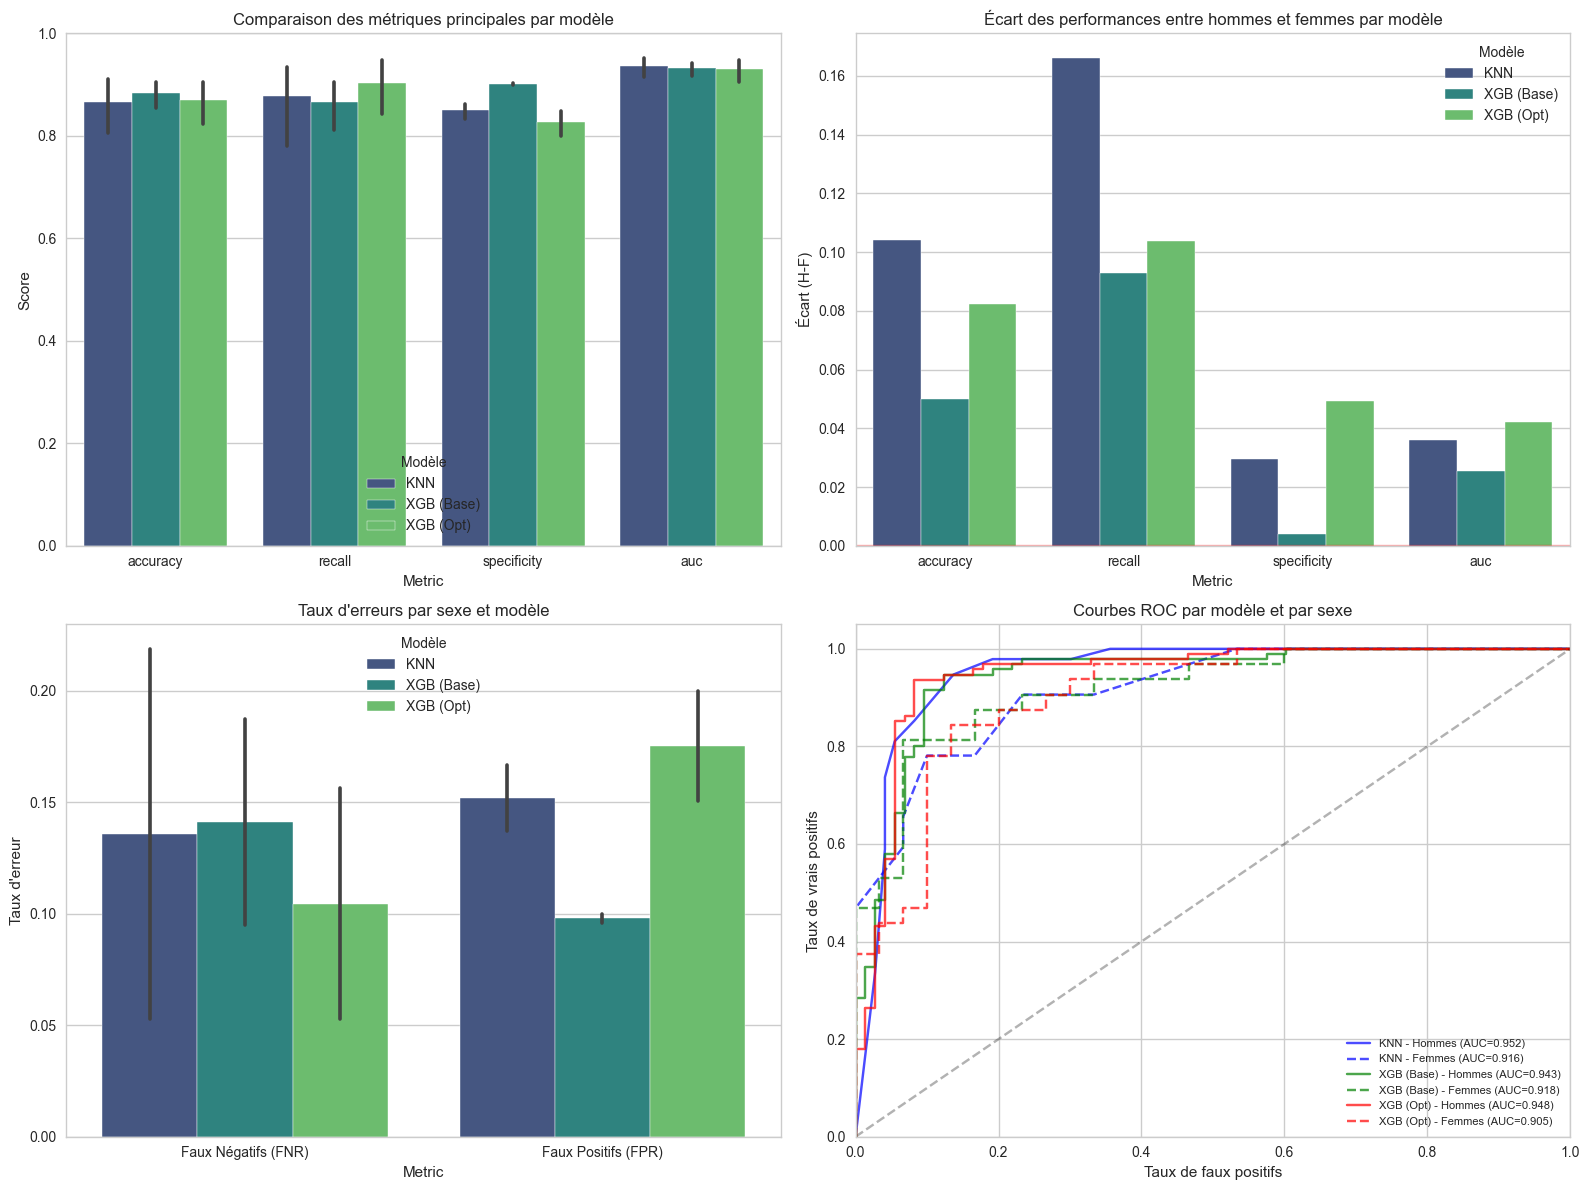

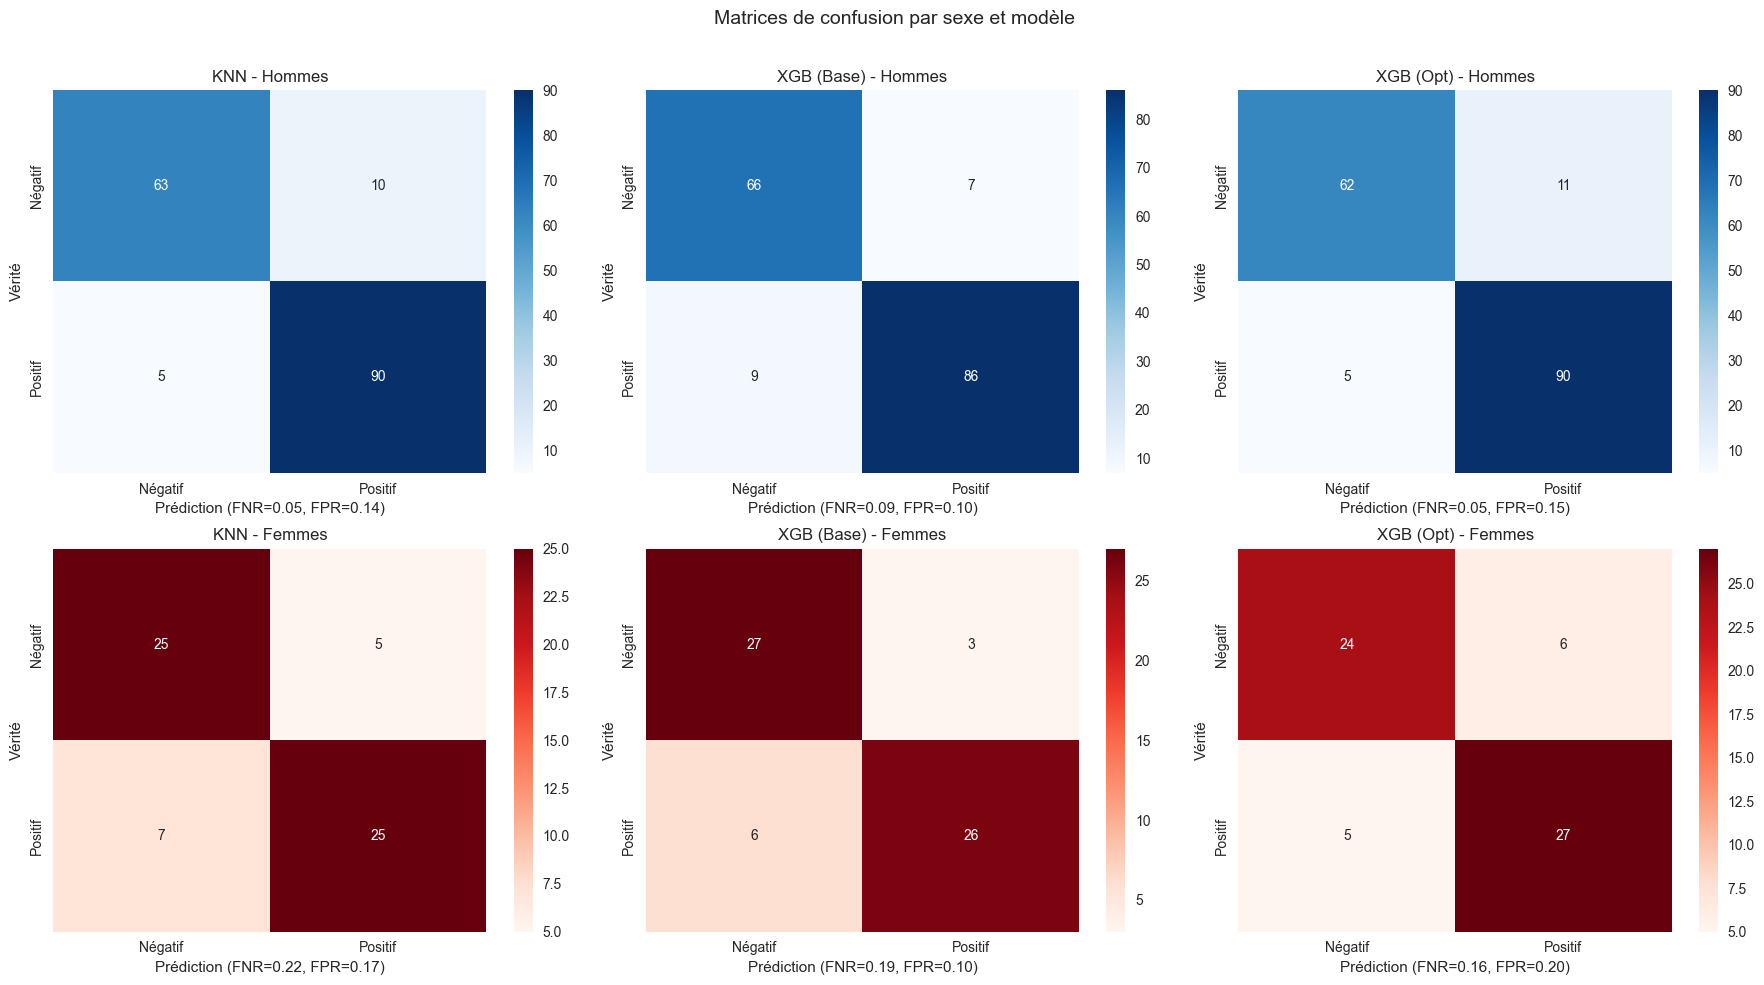

In [27]:
#Créer un DataFrame avec les indices du jeu de test
test_indices = y_test.index

# Récupérer les informations de sexe depuis le DataFrame original
sex_in_test = df.loc[test_indices, 'Sex']

# Créer un DataFrame avec les résultats de prédiction pour tous les modèles
results_df = pd.DataFrame({
    'Sex': sex_in_test,
    'TrueLabel': y_test,
    'Predicted_KNN': y_pred_knn,
    'Predicted_XGB_Base': y_pred_xgb,
    'Predicted_XGB_Opt': y_pred_xgb_optimized,
    'Prob_KNN': y_prob_knn,
    'Prob_XGB_Base': y_prob_xgb,
    'Prob_XGB_Opt': y_prob_xgb_optimized
})

# Fonction complète pour analyser les performances par sexe
def analyze_by_sex(results_df, model_suffix):
    """Analyser les performances d'un modèle par sexe avec métriques complètes"""
    male_results = results_df[results_df['Sex'] == 'M']
    female_results = results_df[results_df['Sex'] == 'F']
    
    # Colonnes des prédictions et probabilités
    pred_col = f'Predicted_{model_suffix}'
    prob_col = f'Prob_{model_suffix}'
    
    # Métriques pour hommes
    if len(male_results) > 0:
        male_metrics = {
            'accuracy': accuracy_score(male_results['TrueLabel'], male_results[pred_col]),
            'precision': precision_score(male_results['TrueLabel'], male_results[pred_col]),
            'f1': f1_score(male_results['TrueLabel'], male_results[pred_col]),
            'recall': recall_score(male_results['TrueLabel'], male_results[pred_col]),
            'auc': roc_auc_score(male_results['TrueLabel'], male_results[prob_col])
        }
        
        male_cm = confusion_matrix(male_results['TrueLabel'], male_results[pred_col])
        tn_m, fp_m, fn_m, tp_m = male_cm.ravel()
        male_metrics['fnr'] = fn_m / (fn_m + tp_m) if (fn_m + tp_m) > 0 else 0
        male_metrics['fpr'] = fp_m / (fp_m + tn_m) if (fp_m + tn_m) > 0 else 0
        male_metrics['specificity'] = tn_m / (tn_m + fp_m) if (tn_m + fp_m) > 0 else 0
    else:
        male_metrics = {metric: np.nan for metric in 
                       ['accuracy', 'precision', 'f1', 'recall', 'auc', 'fnr', 'fpr', 'specificity']}
        male_cm = np.zeros((2, 2))
    
    # Métriques pour femmes
    if len(female_results) > 0:
        female_metrics = {
            'accuracy': accuracy_score(female_results['TrueLabel'], female_results[pred_col]),
            'precision': precision_score(female_results['TrueLabel'], female_results[pred_col]),
            'f1': f1_score(female_results['TrueLabel'], female_results[pred_col]),
            'recall': recall_score(female_results['TrueLabel'], female_results[pred_col]),
            'auc': roc_auc_score(female_results['TrueLabel'], female_results[prob_col])
        }
        
        female_cm = confusion_matrix(female_results['TrueLabel'], female_results[pred_col])
        tn_f, fp_f, fn_f, tp_f = female_cm.ravel()
        female_metrics['fnr'] = fn_f / (fn_f + tp_f) if (fn_f + tp_f) > 0 else 0
        female_metrics['fpr'] = fp_f / (fp_f + tn_f) if (fp_f + tn_f) > 0 else 0
        female_metrics['specificity'] = tn_f / (tn_f + fp_f) if (tn_f + fp_f) > 0 else 0
    else:
        female_metrics = {metric: np.nan for metric in 
                         ['accuracy', 'precision', 'f1', 'recall', 'auc', 'fnr', 'fpr', 'specificity']}
        female_cm = np.zeros((2, 2))
    
    # Calculer l'écart entre les sexes
    gap_metrics = {
        metric: male_metrics[metric] - female_metrics[metric] 
        for metric in male_metrics.keys()
    }
    
    return {
        'male': male_metrics, 
        'female': female_metrics,
        'gap': gap_metrics,
        'male_cm': male_cm,
        'female_cm': female_cm,
        'male_count': len(male_results),
        'female_count': len(female_results),
        'male_data': male_results,
        'female_data': female_results
    }

# Analyser chaque modèle
model_names = ['KNN', 'XGB_Base', 'XGB_Opt']
sex_results = {}

for model in model_names:
    sex_results[model] = analyze_by_sex(results_df, model)

# Créer un DataFrame pour comparer toutes les métriques des modèles par sexe
metrics_to_display = ['accuracy', 'precision', 'recall', 'specificity', 'f1', 'auc', 'fnr', 'fpr']
comparison_data = []

for model in model_names:
    # Métriques globales - calculées sur l'ensemble du test
    if model == 'KNN':
        y_pred = y_pred_knn
        y_prob = y_prob_knn
    elif model == 'XGB_Base':
        y_pred = y_pred_xgb
        y_prob = y_prob_xgb
    elif model == 'XGB_Opt':
        y_pred = y_pred_xgb_optimized
        y_prob = y_prob_xgb_optimized
    
    overall_cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = overall_cm.ravel()
    
    overall_metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
        'f1': f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_prob),
        'fnr': fn / (fn + tp) if (fn + tp) > 0 else 0,
        'fpr': fp / (fp + tn) if (fp + tn) > 0 else 0
    }
    
    # Ajouter à la liste de comparaison
    for metric in metrics_to_display:
        comparison_data.append({
            'Model': model.replace('_Base', ' (Base)').replace('_Opt', ' (Opt)'),
            'Metric': metric,
            'Overall': overall_metrics[metric],
            'Male': sex_results[model]['male'][metric],
            'Female': sex_results[model]['female'][metric],
            'Gap': sex_results[model]['gap'][metric]
        })

# Créer un DataFrame avec toutes les métriques
comparison_df = pd.DataFrame(comparison_data)

# Pivoter pour une meilleure visualisation
comparison_pivot = comparison_df.pivot_table(
    index=['Model', 'Metric'], 
    values=['Overall', 'Male', 'Female', 'Gap'],
    aggfunc='first'
).reset_index()

# Formater les métriques pour l'affichage
for col in ['Overall', 'Male', 'Female', 'Gap']:
    comparison_pivot[col] = comparison_pivot[col].map(lambda x: f"{x:.4f}")

# Afficher le tableau comparatif
print("\nComparaison complète des métriques par modèle et par sexe:")
comparison_table = comparison_pivot.pivot(index=['Model', 'Metric'], columns=[]).reset_index()
print(comparison_table)

# Sauvegarder les données pour une visualisation
metrics_for_vis = comparison_df.copy()

# Visualisations
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 10})

# 1. Visualisation des principales métriques par sexe et modèle
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Sélectionner les métriques clés
key_metrics = ['accuracy', 'recall', 'specificity', 'auc']

# 1.1 Comparaison globale des métriques clés
ax1 = plt.subplot(gs[0, 0])
metric_data = comparison_df[comparison_df['Metric'].isin(key_metrics)]

# Réorganiser les données pour Seaborn
plot_data = pd.melt(
    metric_data, 
    id_vars=['Model', 'Metric'], 
    value_vars=['Overall', 'Male', 'Female'],
    var_name='Gender', value_name='Value'
)

sns.barplot(
    data=plot_data, 
    x='Metric', y='Value', hue='Model', 
    palette='viridis', 
    ax=ax1
)
ax1.set_title('Comparaison des métriques principales par modèle', fontsize=12)
ax1.set_ylim(0, 1)
ax1.set_ylabel('Score')
ax1.legend(title='Modèle')

# 1.2 Écart entre les sexes (hommes vs femmes)
ax2 = plt.subplot(gs[0, 1])

# Filtrer pour n'avoir que les écarts de métriques clés
gap_data = comparison_df[comparison_df['Metric'].isin(key_metrics)].copy()

sns.barplot(
    data=gap_data, 
    x='Metric', y='Gap', hue='Model',
    palette='viridis', 
    ax=ax2
)
ax2.set_title('Écart des performances entre hommes et femmes par modèle', fontsize=12)
ax2.set_ylabel('Écart (H-F)')
ax2.axhline(y=0, color='r', linestyle='-', alpha=0.3)
ax2.legend(title='Modèle')

# 2. Analyse des taux d'erreur par sexe
ax3 = plt.subplot(gs[1, 0])

# Filtrer pour les taux d'erreur
error_metrics = ['fnr', 'fpr']
error_data = comparison_df[comparison_df['Metric'].isin(error_metrics)].copy()

# Réorganiser pour Seaborn
error_plot = pd.melt(
    error_data, 
    id_vars=['Model', 'Metric'], 
    value_vars=['Male', 'Female'],
    var_name='Gender', value_name='Value'
)

# Tracer le graphique des erreurs
sns.barplot(
    data=error_plot, 
    x='Metric', y='Value', hue='Model',
    palette='viridis', 
    ax=ax3
)
ax3.set_title('Taux d\'erreurs par sexe et modèle', fontsize=12)
ax3.set_ylabel('Taux d\'erreur')
ax3.set_xticklabels(['Faux Négatifs (FNR)', 'Faux Positifs (FPR)'])
ax3.legend(title='Modèle')

# 3. Courbes ROC comparées par sexe pour chaque modèle
ax4 = plt.subplot(gs[1, 1])

# Tracer les courbes ROC pour chaque modèle et par sexe
line_styles = ['-', '--', '-.']
colors = ['blue', 'green', 'red']

for i, model in enumerate(model_names):
    # Données par sexe pour ce modèle
    male_data = sex_results[model]['male_data']
    female_data = sex_results[model]['female_data']
    prob_col = f'Prob_{model}'
    
    # Courbe ROC pour les hommes
    if len(male_data) > 0:
        fpr_m, tpr_m, _ = roc_curve(male_data['TrueLabel'], male_data[prob_col])
        roc_auc_m = auc(fpr_m, tpr_m)
        ax4.plot(fpr_m, tpr_m, linestyle=line_styles[0], color=colors[i],
                 label=f'{model.replace("_Base", " (Base)").replace("_Opt", " (Opt)")} - Hommes (AUC={roc_auc_m:.3f})', 
                 alpha=0.7)
    
    # Courbe ROC pour les femmes
    if len(female_data) > 0:
        fpr_f, tpr_f, _ = roc_curve(female_data['TrueLabel'], female_data[prob_col])
        roc_auc_f = auc(fpr_f, tpr_f)
        ax4.plot(fpr_f, tpr_f, linestyle=line_styles[1], color=colors[i],
                 label=f'{model.replace("_Base", " (Base)").replace("_Opt", " (Opt)")} - Femmes (AUC={roc_auc_f:.3f})', 
                 alpha=0.7)

ax4.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax4.set_xlim([0.0, 1.0])
ax4.set_ylim([0.0, 1.05])
ax4.set_xlabel('Taux de faux positifs')
ax4.set_ylabel('Taux de vrais positifs')
ax4.set_title('Courbes ROC par modèle et par sexe', fontsize=12)
ax4.legend(loc="lower right", fontsize=8)

plt.tight_layout()
plt.savefig('model_comparison_by_sex.png', dpi=300)
plt.show()

# Visualisation des matrices de confusion par sexe pour tous les modèles
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Matrices de confusion par sexe et modèle', fontsize=14)

for i, model in enumerate(model_names):
    # Matrice de confusion pour les hommes
    male_cm = sex_results[model]['male_cm']
    sns.heatmap(male_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, i],
                xticklabels=['Négatif', 'Positif'], yticklabels=['Négatif', 'Positif'])
    axes[0, i].set_title(f'{model.replace("_Base", " (Base)").replace("_Opt", " (Opt)")} - Hommes')
    axes[0, i].set_ylabel('Vérité')
    axes[0, i].set_xlabel('Prédiction')
    
    # Calcul des taux
    if male_cm.sum() > 0:
        tn, fp, fn, tp = male_cm.ravel()
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        axes[0, i].set_xlabel(f'Prédiction (FNR={fnr:.2f}, FPR={fpr:.2f})')
    
    # Matrice de confusion pour les femmes
    female_cm = sex_results[model]['female_cm']
    sns.heatmap(female_cm, annot=True, fmt='d', cmap='Reds', ax=axes[1, i],
                xticklabels=['Négatif', 'Positif'], yticklabels=['Négatif', 'Positif'])
    axes[1, i].set_title(f'{model.replace("_Base", " (Base)").replace("_Opt", " (Opt)")} - Femmes')
    axes[1, i].set_ylabel('Vérité')
    axes[1, i].set_xlabel('Prédiction')
    
    # Calcul des taux
    if female_cm.sum() > 0:
        tn, fp, fn, tp = female_cm.ravel()
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        axes[1, i].set_xlabel(f'Prédiction (FNR={fnr:.2f}, FPR={fpr:.2f})')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig('images/recap', dpi=300)
plt.show()


Tableau récapitulatif des métriques clés par modèle et par sexe:
        Modèle     Métrique  Hommes  Femmes Écart (H-F)
0          KNN     accuracy  0.9107  0.8065      0.1043
1          KNN    precision  0.9000  0.8333      0.0667
2          KNN       recall  0.9474  0.7812      0.1661
3          KNN  specificity  0.8630  0.8333      0.0297
4          KNN           f1  0.9231  0.8065      0.1166
5          KNN          auc  0.9518  0.9156      0.0361
6          KNN          fnr  0.0526  0.2188     -0.1661
7   XGB (Base)     accuracy  0.9048  0.8548      0.0499
8   XGB (Base)    precision  0.9247  0.8966      0.0282
9   XGB (Base)       recall  0.9053  0.8125      0.0928
10  XGB (Base)  specificity  0.9041  0.9000      0.0041
11  XGB (Base)           f1  0.9149  0.8525      0.0624
12  XGB (Base)          auc  0.9430  0.9177      0.0253
13  XGB (Base)          fnr  0.0947  0.1875     -0.0928
14   XGB (Opt)     accuracy  0.9048  0.8226      0.0822
15   XGB (Opt)    precision  0.8911  0

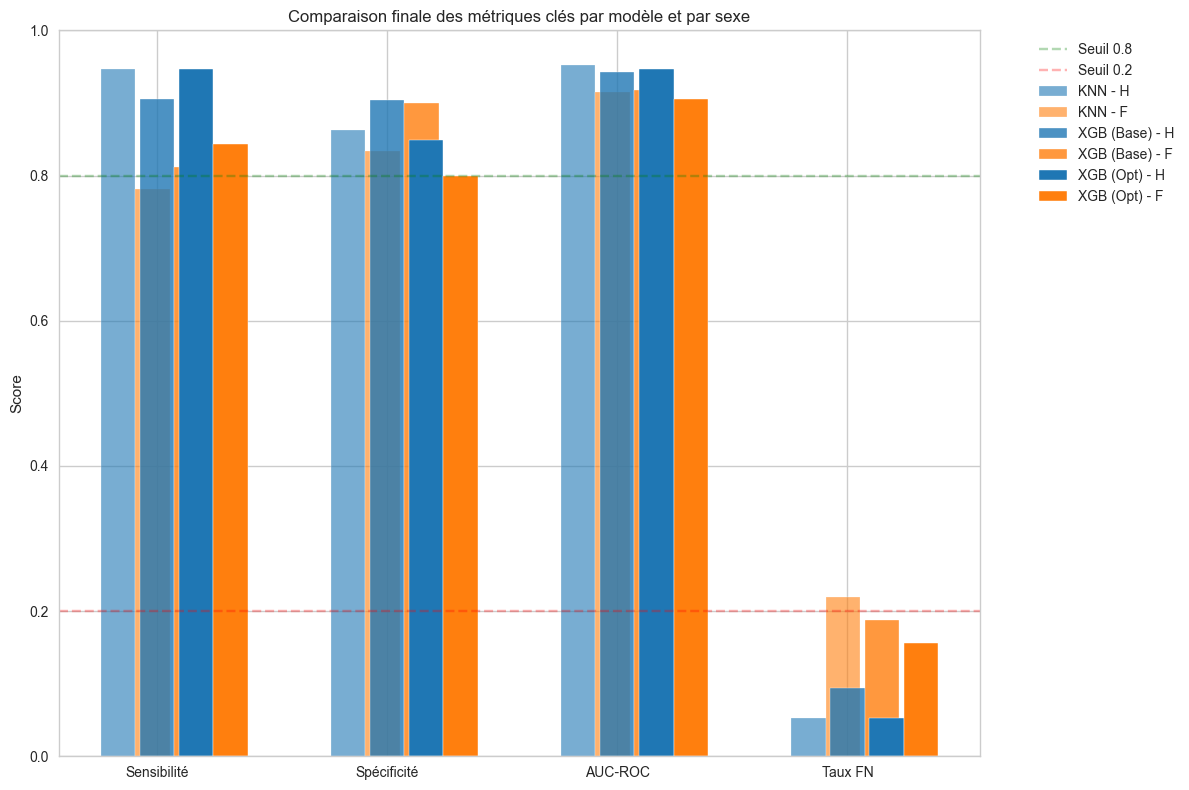


=== RÉSUMÉ DE L'ANALYSE COMPARATIVE DES MODÈLES PAR SEXE ===

1. Performance globale:
  - KNN: AUC=0.9419, Sensibilité=0.9055, Taux FN=0.0945
  - XGB (Base): AUC=0.9352, Sensibilité=0.8819, Taux FN=0.1181
  - XGB (Opt): AUC=0.9365, Sensibilité=0.9213, Taux FN=0.0787

2. Écarts de performance entre hommes et femmes:
  - KNN:
      AUC: H=0.9518, F=0.9156, Écart=0.0361
      Sensibilité: H=0.9474, F=0.7812, Écart=0.1661
      Taux FN: H=0.0526, F=0.2188, Écart=-0.1661
  - XGB (Base):
      AUC: H=0.9430, F=0.9177, Écart=0.0253
      Sensibilité: H=0.9053, F=0.8125, Écart=0.0928
      Taux FN: H=0.0947, F=0.1875, Écart=-0.0928
  - XGB (Opt):
      AUC: H=0.9475, F=0.9052, Écart=0.0423
      Sensibilité: H=0.9474, F=0.8438, Écart=0.1036
      Taux FN: H=0.0526, F=0.1562, Écart=-0.1036

3. Meilleur modèle global:
  Le meilleur modèle global est KNN avec AUC=0.9419

4. Modèle le plus équitable entre les sexes:
  Le modèle le plus équitable est XGB (Base) 
  avec un écart de taux de faux nég

In [28]:
# Créer un tableau récapitulatif des métriques clés par modèle et par sexe
key_metrics = ['accuracy', 'precision', 'recall', 'specificity', 'f1', 'auc', 'fnr']
summary_data = []

for model in model_names:
    model_name = model.replace('_Base', ' (Base)').replace('_Opt', ' (Opt)')
    
    # Obtenir les métriques pour ce modèle
    male_metrics = sex_results[model]['male']
    female_metrics = sex_results[model]['female']
    
    # Ajouter les données au tableau récapitulatif
    for metric in key_metrics:
        if metric in male_metrics and metric in female_metrics:
            summary_data.append({
                'Modèle': model_name,
                'Métrique': metric,
                'Hommes': f"{male_metrics[metric]:.4f}",
                'Femmes': f"{female_metrics[metric]:.4f}",
                'Écart (H-F)': f"{male_metrics[metric] - female_metrics[metric]:.4f}"
            })

# Créer un DataFrame pour le tableau récapitulatif
summary_df = pd.DataFrame(summary_data)

# Afficher le tableau récapitulatif
print("\nTableau récapitulatif des métriques clés par modèle et par sexe:")
print(summary_df)

# Créer une visualisation comparant les métriques finales des trois modèles
metrics_for_final_vis = ['recall', 'specificity', 'auc', 'fnr']

fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(metrics_for_final_vis))
width = 0.2
multiplier = 0

# Couleurs pour différencier hommes et femmes
colors = {'Male': '#1f77b4', 'Female': '#ff7f0e'}

# Largeur des barres
bar_width = 0.15
spacing = 0.02

for model in model_names:
    male_metrics = sex_results[model]['male']
    female_metrics = sex_results[model]['female']
    
    offset = multiplier * (bar_width + spacing)
    
    # Barres pour les hommes
    male_values = [male_metrics[metric] for metric in metrics_for_final_vis]
    ax.bar(x + offset, male_values, bar_width, label=f'{model.replace("_Base", " (Base)").replace("_Opt", " (Opt)")} - H', 
           color=colors['Male'], alpha=0.6 + 0.2*multiplier)
    
    # Barres pour les femmes
    female_values = [female_metrics[metric] for metric in metrics_for_final_vis]
    ax.bar(x + offset + bar_width, female_values, bar_width, 
           label=f'{model.replace("_Base", " (Base)").replace("_Opt", " (Opt)")} - F', 
           color=colors['Female'], alpha=0.6 + 0.2*multiplier)
    
    multiplier += 1

# Ajouter des lignes horizontales pour les valeurs importantes
ax.axhline(y=0.8, color='green', linestyle='--', alpha=0.3, label='Seuil 0.8')
ax.axhline(y=0.2, color='red', linestyle='--', alpha=0.3, label='Seuil 0.2')

# Finitions
ax.set_ylabel('Score')
ax.set_title('Comparaison finale des métriques clés par modèle et par sexe')
ax.set_xticks(x + (len(model_names)-1)/2 * (bar_width + spacing))
ax.set_xticklabels(['Sensibilité', 'Spécificité', 'AUC-ROC', 'Taux FN'])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('final_metrics_comparison.png', dpi=300)
plt.show()

# Résumé des principales conclusions
print("\n=== RÉSUMÉ DE L'ANALYSE COMPARATIVE DES MODÈLES PAR SEXE ===")
print("\n1. Performance globale:")
for model in model_names:
    model_disp = model.replace('_Base', ' (Base)').replace('_Opt', ' (Opt)')
    if model == 'KNN':
        auc_val = roc_auc_score(y_test, y_prob_knn)
        recall_val = recall_score(y_test, y_pred_knn)
        fnr_val = 1 - recall_val
    elif model == 'XGB_Base':
        auc_val = roc_auc_score(y_test, y_prob_xgb)
        recall_val = recall_score(y_test, y_pred_xgb)
        fnr_val = 1 - recall_val
    else:
        auc_val = roc_auc_score(y_test, y_prob_xgb_optimized)
        recall_val = recall_score(y_test, y_pred_xgb_optimized)
        fnr_val = 1 - recall_val
    
    print(f"  - {model_disp}: AUC={auc_val:.4f}, Sensibilité={recall_val:.4f}, Taux FN={fnr_val:.4f}")

print("\n2. Écarts de performance entre hommes et femmes:")
for model in model_names:
    model_disp = model.replace('_Base', ' (Base)').replace('_Opt', ' (Opt)')
    male_auc = sex_results[model]['male']['auc']
    female_auc = sex_results[model]['female']['auc']
    male_recall = sex_results[model]['male']['recall']
    female_recall = sex_results[model]['female']['recall']
    male_fnr = sex_results[model]['male']['fnr']
    female_fnr = sex_results[model]['female']['fnr']
    
    print(f"  - {model_disp}:")
    print(f"      AUC: H={male_auc:.4f}, F={female_auc:.4f}, Écart={male_auc-female_auc:.4f}")
    print(f"      Sensibilité: H={male_recall:.4f}, F={female_recall:.4f}, Écart={male_recall-female_recall:.4f}")
    print(f"      Taux FN: H={male_fnr:.4f}, F={female_fnr:.4f}, Écart={male_fnr-female_fnr:.4f}")

print("\n3. Meilleur modèle global:")
best_overall_model = ''
best_auc = 0
for model in model_names:
    if model == 'KNN':
        auc_val = roc_auc_score(y_test, y_prob_knn)
    elif model == 'XGB_Base':
        auc_val = roc_auc_score(y_test, y_prob_xgb)
    else:
        auc_val = roc_auc_score(y_test, y_prob_xgb_optimized)
    
    if auc_val > best_auc:
        best_auc = auc_val
        best_overall_model = model

print(f"  Le meilleur modèle global est {best_overall_model.replace('_Base', ' (Base)').replace('_Opt', ' (Opt)')} avec AUC={best_auc:.4f}")

print("\n4. Modèle le plus équitable entre les sexes:")
smallest_fnr_gap = float('inf')
most_fair_model = ''
for model in model_names:
    fnr_gap = abs(sex_results[model]['male']['fnr'] - sex_results[model]['female']['fnr'])
    if fnr_gap < smallest_fnr_gap:
        smallest_fnr_gap = fnr_gap
        most_fair_model = model

print(f"  Le modèle le plus équitable est {most_fair_model.replace('_Base', ' (Base)').replace('_Opt', ' (Opt)')} ")
print(f"  avec un écart de taux de faux négatifs entre H/F de {smallest_fnr_gap:.4f}")

print("\n5. Recommandation finale:")
if most_fair_model == best_overall_model:
    print(f"  Le modèle {most_fair_model.replace('_Base', ' (Base)').replace('_Opt', ' (Opt)')} est recommandé car il offre")
    print(f"  à la fois la meilleure performance globale et la plus grande équité entre les sexes.")
else:
    # Comparer l'écart de performance entre le meilleur modèle et le plus équitable
    best_auc = 0
    if best_overall_model == 'KNN':
        best_auc = roc_auc_score(y_test, y_prob_knn)
    elif best_overall_model == 'XGB_Base':
        best_auc = roc_auc_score(y_test, y_prob_xgb)
    else:
        best_auc = roc_auc_score(y_test, y_prob_xgb_optimized)
    
    fair_auc = 0
    if most_fair_model == 'KNN':
        fair_auc = roc_auc_score(y_test, y_prob_knn)
    elif most_fair_model == 'XGB_Base':
        fair_auc = roc_auc_score(y_test, y_prob_xgb)
    else:
        fair_auc = roc_auc_score(y_test, y_prob_xgb_optimized)
    
    auc_diff = best_auc - fair_auc
    
    if auc_diff < 0.05:  # Si l'écart est petit, privilégier l'équité
        print(f"  Le modèle {most_fair_model.replace('_Base', ' (Base)').replace('_Opt', ' (Opt)')} est recommandé pour son équité entre les sexes")
        print(f"  avec une performance globale (AUC={fair_auc:.4f}) proche du meilleur modèle ({best_auc:.4f}).")
    else:
        print(f"  Compromis nécessaire entre performance et équité:")
        print(f"  - Pour la meilleure performance: {best_overall_model.replace('_Base', ' (Base)').replace('_Opt', ' (Opt)')} (AUC={best_auc:.4f})")
        print(f"  - Pour la meilleure équité: {most_fair_model.replace('_Base', ' (Base)').replace('_Opt', ' (Opt)')} (écart FNR={smallest_fnr_gap:.4f})")

### 10. COMPARAISON DES PERFORMANCES DES MODÈLES

In [29]:
print("\nComparaison des performances:")
print(f"KNN (k={best_k}) - Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}, F1-score: {f1_score(y_test, y_pred_knn):.4f}, AUC-ROC: {roc_auc_score(y_test, y_prob_knn):.4f}")
print(f"XGBoost - Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}, F1-score: {f1_score(y_test, y_pred_xgb):.4f}, AUC-ROC: {roc_auc_score(y_test, y_prob_xgb):.4f}")

# 10. IMPORTANCE DES VARIABLES POUR XGBOOST

# Obtenir l'importance des variables pour XGBoost
feature_importance = xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

print("\nImportance des variables selon XGBoost:")
for i in sorted_idx[::-1]:
    print(f"{X_train_xgb.columns[i]}: {feature_importance[i]:.4f}")


Comparaison des performances:
KNN (k=13) - Accuracy: 0.8826, F1-score: 0.8949, AUC-ROC: 0.9419
XGBoost - Accuracy: 0.8913, F1-score: 0.8996, AUC-ROC: 0.9352


NotFittedError: need to call fit or load_model beforehand

In [ ]:
if __name__ == "__main__":
    pass  
